# Start with smile

https://createmomo.github.io/2017/11/11/CRF-Layer-on-the-Top-of-BiLSTM-5/



https://github.com/Hironsan/keras-crf-layer


https://github.com/keunwoochoi/kapre#one-shot-example


https://github.com/keunwoochoi/keras_STFT_layer

In [0]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#@title 

import numpy as np
from sklearn.model_selection import train_test_split
from glob import glob
import os
!pip install git+https://www.github.com/keras-team/keras-contrib.git
import keras
from keras import optimizers, losses, activations, models
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from keras.utils import plot_model
from keras.utils.vis_utils import plot_model
import IPython
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_contrib.layers import CRF
from keras.layers import Convolution2D, MaxPool2D, GlobalMaxPool2D, GlobalAveragePooling2D, SpatialDropout2D

#from models import get_model_cnn
import numpy as np
#from utils import gen, chunker, WINDOW_SIZE, rescale_array
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import f1_score, accuracy_score, classification_report
from glob import glob
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Sequential
import matplotlib.pyplot as plt
import numpy
from sklearn.preprocessing import StandardScaler
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-4i6l6aa_
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-4i6l6aa_
  Stored in directory: /tmp/pip-ephem-wheel-cache-yhn079tq/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib


Using TensorFlow backend.


In [0]:
import tensorflow as tf
from keras import backend as K
from keras.engine import Layer, InputSpec

try:
    from tensorflow.contrib.crf import crf_decode
except ImportError:
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import array_ops, gen_array_ops, math_ops, rnn, rnn_cell


    class CrfDecodeForwardRnnCell(rnn_cell.RNNCell):
        """Computes the forward decoding in a linear-chain CRF.
        """

        def __init__(self, transition_params):
            """Initialize the CrfDecodeForwardRnnCell.
            Args:
              transition_params: A [num_tags, num_tags] matrix of binary
                potentials. This matrix is expanded into a
                [1, num_tags, num_tags] in preparation for the broadcast
                summation occurring within the cell.
            """
            self._transition_params = array_ops.expand_dims(transition_params, 0)
            self._num_tags = transition_params.get_shape()[0].value

        @property
        def state_size(self):
            return self._num_tags

        @property
        def output_size(self):
            return self._num_tags

        def __call__(self, inputs, state, scope=None):
            """Build the CrfDecodeForwardRnnCell.
            Args:
              inputs: A [batch_size, num_tags] matrix of unary potentials.
              state: A [batch_size, num_tags] matrix containing the previous step's
                    score values.
              scope: Unused variable scope of this cell.
            Returns:
              backpointers: [batch_size, num_tags], containing backpointers.
              new_state: [batch_size, num_tags], containing new score values.
            """
            # For simplicity, in shape comments, denote:
            # 'batch_size' by 'B', 'max_seq_len' by 'T' , 'num_tags' by 'O' (output).
            state = array_ops.expand_dims(state, 2)  # [B, O, 1]

            # This addition op broadcasts self._transitions_params along the zeroth
            # dimension and state along the second dimension.
            # [B, O, 1] + [1, O, O] -> [B, O, O]
            transition_scores = state + self._transition_params  # [B, O, O]
            new_state = inputs + math_ops.reduce_max(transition_scores, [1])  # [B, O]
            backpointers = math_ops.argmax(transition_scores, 1)
            backpointers = math_ops.cast(backpointers, dtype=dtypes.int32)  # [B, O]
            return backpointers, new_state


    class CrfDecodeBackwardRnnCell(rnn_cell.RNNCell):
        """Computes backward decoding in a linear-chain CRF.
        """

        def __init__(self, num_tags):
            """Initialize the CrfDecodeBackwardRnnCell.
            Args:
              num_tags
            """
            self._num_tags = num_tags

        @property
        def state_size(self):
            return 1

        @property
        def output_size(self):
            return 1

        def __call__(self, inputs, state, scope=None):
            """Build the CrfDecodeBackwardRnnCell.
            Args:
              inputs: [batch_size, num_tags], backpointer of next step (in time order).
              state: [batch_size, 1], next position's tag index.
              scope: Unused variable scope of this cell.
            Returns:
              new_tags, new_tags: A pair of [batch_size, num_tags]
                tensors containing the new tag indices.
            """
            state = array_ops.squeeze(state, axis=[1])  # [B]
            batch_size = array_ops.shape(inputs)[0]
            b_indices = math_ops.range(batch_size)  # [B]
            indices = array_ops.stack([b_indices, state], axis=1)  # [B, 2]
            new_tags = array_ops.expand_dims(
                gen_array_ops.gather_nd(inputs, indices),  # [B]
                axis=-1)  # [B, 1]

            return new_tags, new_tags


    def crf_decode(potentials, transition_params, sequence_length):
        """Decode the highest scoring sequence of tags in TensorFlow.
        This is a function for tensor.
        Args:
        potentials: A [batch_size, max_seq_len, num_tags] tensor, matrix of
                  unary potentials.
        transition_params: A [num_tags, num_tags] tensor, matrix of
                  binary potentials.
        sequence_length: A [batch_size] tensor, containing sequence lengths.
        Returns:
        decode_tags: A [batch_size, max_seq_len] tensor, with dtype tf.int32.
                    Contains the highest scoring tag indicies.
        best_score: A [batch_size] tensor, containing the score of decode_tags.
        """
        # For simplicity, in shape comments, denote:
        # 'batch_size' by 'B', 'max_seq_len' by 'T' , 'num_tags' by 'O' (output).
        num_tags = potentials.get_shape()[2].value

        # Computes forward decoding. Get last score and backpointers.
        crf_fwd_cell = CrfDecodeForwardRnnCell(transition_params)
        initial_state = array_ops.slice(potentials, [0, 0, 0], [-1, 1, -1])
        initial_state = array_ops.squeeze(initial_state, axis=[1])  # [B, O]
        inputs = array_ops.slice(potentials, [0, 1, 0], [-1, -1, -1])  # [B, T-1, O]
        backpointers, last_score = rnn.dynamic_rnn(
            crf_fwd_cell,
            inputs=inputs,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, O], [B, O]
        backpointers = gen_array_ops.reverse_sequence(backpointers, sequence_length - 1, seq_dim=1)  # [B, T-1, O]

        # Computes backward decoding. Extract tag indices from backpointers.
        crf_bwd_cell = CrfDecodeBackwardRnnCell(num_tags)
        initial_state = math_ops.cast(math_ops.argmax(last_score, axis=1), dtype=dtypes.int32)  # [B]
        initial_state = array_ops.expand_dims(initial_state, axis=-1)  # [B, 1]
        decode_tags, _ = rnn.dynamic_rnn(
            crf_bwd_cell,
            inputs=backpointers,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, 1]
        decode_tags = array_ops.squeeze(decode_tags, axis=[2])  # [B, T - 1]
        decode_tags = array_ops.concat([initial_state, decode_tags], axis=1)  # [B, T]
        decode_tags = gen_array_ops.reverse_sequence(decode_tags, sequence_length, seq_dim=1)  # [B, T]

        best_score = math_ops.reduce_max(last_score, axis=1)  # [B]
        return decode_tags, best_score


class CRFLayer(Layer):

    def __init__(self, transition_params=None, **kwargs):
        super(CRFLayer, self).__init__(**kwargs)
        self.transition_params = transition_params
        self.input_spec = [InputSpec(ndim=3), InputSpec(ndim=2)]
        self.supports_masking = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape[0]) == 3

        return input_shape[0]

    def build(self, input_shape):
        """Creates the layer weights.
        Args:
            input_shape (list(tuple, tuple)): [(batch_size, n_steps, n_classes), (batch_size, 1)]
        """
        assert len(input_shape) == 2
        assert len(input_shape[0]) == 3
        assert len(input_shape[1]) == 2
        n_steps = input_shape[0][1]
        n_classes = input_shape[0][2]
        assert n_steps is None or n_steps >= 2

        self.transition_params = self.add_weight(shape=(n_classes, n_classes),
                                                 initializer='uniform',
                                                 name='transition')
        self.input_spec = [InputSpec(dtype=K.floatx(), shape=(None, n_steps, n_classes)),
                           InputSpec(dtype='int32', shape=(None, 1))]
        self.built = True

    def viterbi_decode(self, potentials, sequence_length):
        """Decode the highest scoring sequence of tags in TensorFlow.
        This is a function for tensor.
        Args:
            potentials: A [batch_size, max_seq_len, num_tags] tensor, matrix of unary potentials.
            sequence_length: A [batch_size] tensor, containing sequence lengths.
        Returns:
            decode_tags: A [batch_size, max_seq_len] tensor, with dtype tf.int32.
                         Contains the highest scoring tag indicies.
        """
        decode_tags, best_score = crf_decode(potentials, self.transition_params, sequence_length)

        return decode_tags

    def call(self, inputs, mask=None, **kwargs):
        inputs, sequence_lengths = inputs
        self.sequence_lengths = K.flatten(sequence_lengths)
        y_pred = self.viterbi_decode(inputs, self.sequence_lengths)
        nb_classes = self.input_spec[0].shape[2]
        y_pred_one_hot = K.one_hot(y_pred, nb_classes)

        return K.in_train_phase(inputs, y_pred_one_hot)

    def loss(self, y_true, y_pred):
        """Computes the log-likelihood of tag sequences in a CRF.
        Args:
            y_true : A (batch_size, n_steps, n_classes) tensor.
            y_pred : A (batch_size, n_steps, n_classes) tensor.
        Returns:
            loss: A scalar containing the log-likelihood of the given sequence of tag indices.
        """
        y_true = K.cast(K.argmax(y_true, axis=-1), dtype='int32')
        log_likelihood, self.transition_params = tf.contrib.crf.crf_log_likelihood(
            y_pred, y_true, self.sequence_lengths, self.transition_params)
        loss = tf.reduce_mean(-log_likelihood)

        return loss

    def get_config(self):
        config = {
            'transition_params': K.eval(self.transition_params),
        }
        base_config = super(CRFLayer, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))


def create_custom_objects():
    """Returns the custom objects, needed for loading a persisted model."""
    instanceHolder = {'instance': None}

    class ClassWrapper(CRFLayer):
        def __init__(self, *args, **kwargs):
            instanceHolder['instance'] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instanceHolder['instance'], 'loss')
        return method(*args)

    return {'CRFLayer': ClassWrapper, 'loss': loss}

In [0]:
import numpy as np
from keras.layers import Embedding, Input
from keras.models import Model


# Hyperparameter settings.
vocab_size = 20
n_classes = 11
batch_size = 2
maxlen = 2

# Random features.
x = np.random.randint(1, vocab_size, size=(batch_size, maxlen))

# Random tag indices representing the gold sequence.
y = np.random.randint(n_classes, size=(batch_size, maxlen))
y = np.eye(n_classes)[y]

# All sequences in this example have the same length, but they can be variable in a real model.
s = np.asarray([maxlen] * batch_size, dtype='int32')

# Build an example model.
word_ids = Input(batch_shape=(batch_size, maxlen), dtype='int32')
sequence_lengths = Input(batch_shape=[batch_size, 1], dtype='int32')

word_embeddings = Embedding(vocab_size, n_classes)(word_ids)
crf = CRFLayer()
pred = crf(inputs=[word_embeddings, sequence_lengths])
model = Model(inputs=[word_ids, sequence_lengths], outputs=[pred])
model.compile(loss=crf.loss, optimizer='sgd')

# Train first 1 batch.
model.train_on_batch([x, s], y)

# Save the model
model.save('model.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


In [0]:
import unittest

import numpy as np
from keras.layers import Embedding, Input, LSTM, Dropout, Dense, Bidirectional
from keras.models import Model, load_model



class LayerTest(unittest.TestCase):

    def setUp(self):
        self.filename = 'test.h5'

    def test_crf_layer(self):

        # Hyperparameter settings.
        vocab_size = 20
        n_classes = 11
        batch_size = 2
        maxlen = 2

        # Random features.
        x = np.random.randint(1, vocab_size, size=(batch_size, maxlen))

        # Random tag indices representing the gold sequence.
        y = np.random.randint(n_classes, size=(batch_size, maxlen))
        y = np.eye(n_classes)[y]

        # All sequences in this example have the same length, but they can be variable in a real model.
        s = np.asarray([maxlen] * batch_size, dtype='int32')

        # Build a model.
        word_ids = Input(batch_shape=(batch_size, maxlen), dtype='int32')
        word_embeddings = Embedding(vocab_size, n_classes)(word_ids)
        sequence_lengths = Input(batch_shape=[batch_size, 1], dtype='int32')
        crf = CRFLayer()
        pred = crf([word_embeddings, sequence_lengths])
        model = Model(inputs=[word_ids, sequence_lengths], outputs=[pred])
        model.compile(loss=crf.loss, optimizer='sgd')

        # Train first 1 batch.
        model.train_on_batch([x, s], y)

        # Save the model.
        model.save(self.filename)

    def test_load_model(self):
        model = load_model(self.filename, custom_objects=create_custom_objects())

    def test_bilstm_crf(self):

        # Hyperparameter settings.
        vocab_size = 10000
        word_embedding_size = 100
        num_word_lstm_units = 100
        dropout = 0.5
        ntags = 10

        # Build bidirectional lstm-crf model.
        word_ids = Input(batch_shape=(None, None), dtype='int32')
        word_embeddings = Embedding(input_dim=vocab_size,
                                    output_dim=word_embedding_size,
                                    mask_zero=True)(word_ids)

        x = Bidirectional(LSTM(units=num_word_lstm_units, return_sequences=True))(word_embeddings)
        x = Dropout(dropout)(x)
        x = Dense(ntags)(x)

        sequence_lengths = Input(batch_shape=(None, 1), dtype='int32')

        crf = CRFLayer()
        pred = crf([x, sequence_lengths])

        model = Model(inputs=[word_ids, sequence_lengths], outputs=[pred])
        model.compile(loss=crf.loss, optimizer='sgd')

        model.save(self.filename)

In [0]:
%cd/content/drive/My Drive
base_path = "pure_data"

files = sorted(glob(os.path.join(base_path, "*.npz")))

ids = sorted(list(set([x.split("/")[-1][:5] for x in files])))
##ids, SVM_data = train_test_split(ids, test_size=0.09, random_state=1337)
#split by test subject
train_ids, test_ids = train_test_split(ids, test_size=0.4, random_state=0)

train_val, test = [x for x in files if x.split("/")[-1][:5] in train_ids],\
                  [x for x in files if x.split("/")[-1][:5] in test_ids]

train, val = train_test_split(train_val, test_size=0.15, random_state=1)

train_dict = {k: np.load(k) for k in train}
test_dict = {k: np.load(k) for k in test}
val_dict = {k: np.load(k) for k in val}

/content/drive/My Drive


In [0]:
test_dict

{'pure_data/SC4021E0.npz': <numpy.lib.npyio.NpzFile at 0x7f361c823d68>,
 'pure_data/SC4022E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360615db00>,
 'pure_data/SC4101E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360615dc88>,
 'pure_data/SC4102E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360615de10>,
 'pure_data/SC4111E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360615df98>,
 'pure_data/SC4112E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a160>,
 'pure_data/SC4151E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a2e8>,
 'pure_data/SC4152E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a470>,
 'pure_data/SC4161E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a5f8>,
 'pure_data/SC4162E0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a780>,
 'pure_data/ST7011J0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616a908>,
 'pure_data/ST7012J0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616aa90>,
 'pure_data/ST7041J0.npz': <numpy.lib.npyio.NpzFile at 0x7f360616ac18>,
 'pure_data/ST7042J0.npz': <numpy.lib.npyio.NpzFile at 0x7f36061

# SGD
https://ksaluja15.github.io/Learning-Rate-Multipliers-in-Keras/

In [0]:

from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer

class LR_SGD(Optimizer):
    """Stochastic gradient descent optimizer.

    Includes support for momentum,
    learning rate decay, and Nesterov momentum.

    # Arguments
        lr: float >= 0. Learning rate.
        momentum: float >= 0. Parameter updates momentum.
        decay: float >= 0. Learning rate decay over each update.
        nesterov: boolean. Whether to apply Nesterov momentum.
    """

    def __init__(self, lr=0.01, momentum=0., decay=0.,
                 nesterov=False,multipliers=None,**kwargs):
        super(LR_SGD, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.momentum = K.variable(momentum, name='momentum')
            self.decay = K.variable(decay, name='decay')
        self.initial_decay = decay
        self.nesterov = nesterov
        self.lr_multipliers = multipliers

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))
        # momentum
        shapes = [K.int_shape(p) for p in params]
        moments = [K.zeros(shape) for shape in shapes]
        self.weights = [self.iterations] + moments
        for p, g, m in zip(params, grads, moments):
            
            matched_layer = [x for x in self.lr_multipliers.keys() if x in p.name]
            if matched_layer:
                new_lr = lr * self.lr_multipliers[matched_layer[0]]
            else:
                new_lr = lr

            v = self.momentum * m - new_lr * g  # velocity
            self.updates.append(K.update(m, v))

            if self.nesterov:
                new_p = p + self.momentum * v - new_lr * g
            else:
                new_p = p + v

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'momentum': float(K.get_value(self.momentum)),
                  'decay': float(K.get_value(self.decay)),
                  'nesterov': self.nesterov}
        base_config = super(LR_SGD, self).get_config()
        return dict(list(base_config.items()) + list(config.items())) 

# Adam
https://erikbrorson.github.io/2018/04/30/Adam-with-learning-rate-multipliers/

In [0]:
from keras.legacy import interfaces
import keras.backend as K
from keras.optimizers import Optimizer

class Adam_lr_mult(Optimizer):
    """Adam optimizer.
    Adam optimizer, with learning rate multipliers built on Keras implementation
    # Arguments
        lr: float >= 0. Learning rate.
        beta_1: float, 0 < beta < 1. Generally close to 1.
        beta_2: float, 0 < beta < 1. Generally close to 1.
        epsilon: float >= 0. Fuzz factor. If `None`, defaults to `K.epsilon()`.
        decay: float >= 0. Learning rate decay over each update.
        amsgrad: boolean. Whether to apply the AMSGrad variant of this
            algorithm from the paper "On the Convergence of Adam and
            Beyond".
    # References
        - [Adam - A Method for Stochastic Optimization](http://arxiv.org/abs/1412.6980v8)
        - [On the Convergence of Adam and Beyond](https://openreview.net/forum?id=ryQu7f-RZ)
        
    AUTHOR: Erik Brorson
    """

    def __init__(self, lr=0.01, beta_1=0.9, beta_2=0.999,
                 epsilon=None, decay=0.5, amsgrad=False,
                 multipliers=None, debug_verbose=False,**kwargs):
        super(Adam_lr_mult, self).__init__(**kwargs)
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
            self.lr = K.variable(lr, name='lr')
            self.beta_1 = K.variable(beta_1, name='beta_1')
            self.beta_2 = K.variable(beta_2, name='beta_2')
            self.decay = K.variable(decay, name='decay')
        if epsilon is None:
            epsilon = K.epsilon()
        self.epsilon = epsilon
        self.initial_decay = decay
        self.amsgrad = amsgrad
        self.multipliers = multipliers
        self.debug_verbose = debug_verbose

    @interfaces.legacy_get_updates_support
    def get_updates(self, loss, params):
        grads = self.get_gradients(loss, params)
        self.updates = [K.update_add(self.iterations, 1)]

        lr = self.lr
        if self.initial_decay > 0:
            lr *= (1. / (1. + self.decay * K.cast(self.iterations,
                                                  K.dtype(self.decay))))

        t = K.cast(self.iterations, K.floatx()) + 1
        lr_t = lr * (K.sqrt(1. - K.pow(self.beta_2, t)) /
                     (1. - K.pow(self.beta_1, t)))

        ms = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        vs = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        if self.amsgrad:
            vhats = [K.zeros(K.int_shape(p), dtype=K.dtype(p)) for p in params]
        else:
            vhats = [K.zeros(1) for _ in params]
        self.weights = [self.iterations] + ms + vs + vhats

        for p, g, m, v, vhat in zip(params, grads, ms, vs, vhats):

            # Learning rate multipliers
            if self.multipliers:
                multiplier = [mult for mult in self.multipliers if mult in p.name]
            else:
                multiplier = None
            if multiplier:
                new_lr_t = lr_t * self.multipliers[multiplier[0]]
                if self.debug_verbose:
                    print('Setting {} to learning rate {}'.format(multiplier[0], new_lr_t))
                    print(K.get_value(new_lr_t))
            else:
                new_lr_t = lr_t
                if self.debug_verbose:
                    print('No change in learning rate {}'.format(p.name))
                    print(K.get_value(new_lr_t))
            m_t = (self.beta_1 * m) + (1. - self.beta_1) * g
            v_t = (self.beta_2 * v) + (1. - self.beta_2) * K.square(g)
            if self.amsgrad:
                vhat_t = K.maximum(vhat, v_t)
                p_t = p - new_lr_t * m_t / (K.sqrt(vhat_t) + self.epsilon)
                self.updates.append(K.update(vhat, vhat_t))
            else:
                p_t = p - new_lr_t * m_t / (K.sqrt(v_t) + self.epsilon)

            self.updates.append(K.update(m, m_t))
            self.updates.append(K.update(v, v_t))
            new_p = p_t

            # Apply constraints.
            if getattr(p, 'constraint', None) is not None:
                new_p = p.constraint(new_p)

            self.updates.append(K.update(p, new_p))
        return self.updates

    def get_config(self):
        config = {'lr': float(K.get_value(self.lr)),
                  'beta_1': float(K.get_value(self.beta_1)),
                  'beta_2': float(K.get_value(self.beta_2)),
                  'decay': float(K.get_value(self.decay)),
                  'epsilon': self.epsilon,
                  'amsgrad': self.amsgrad,
                  'multipliers':self.multipliers}
        base_config = super(Adam_lr_mult, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [0]:
def balance(dict_files):
  pre0=[]
  y0_pre=[]
  pre1=[]
  y1_pre=[]
  pre2=[]
  y2_pre=[]
  pre3=[]
  y3_pre=[]
  pre4=[]
  y4_pre=[]
  u=0
  v=0
  w=0
  x=0
  y=0
  for record in tqdm(dict_files):
    all_rows = dict_files[record]['x']
    all_cols=dict_files[record]['y']
    for i in range(len(all_cols)):
      if all_cols[i]==0 :
        if x==0:
          pre0=all_rows[i]
          x=x+1
          y0_pre+=[0]
          
        else: 
             pre0 = np.concatenate((pre0,all_rows[i]),axis=0)
             y0_pre+=[0]
      
      if all_cols[i]==1 :
        if u==0:
          pre1=all_rows[i]
          u=u+1
          y1_pre+=[1]
          
        else: 
             pre1 = np.concatenate((pre1,all_rows[i]),axis=0)
             y1_pre+=[1]
              
      if all_cols[i]==2 :
        if y==0:
          pre2=all_rows[i]
          y=y+1
          y2_pre+=[2]
          
        else: 
             pre2 = np.concatenate((pre2,all_rows[i]),axis=0)
             y2_pre+=[2]       
       
      
      
      
      if all_cols[i]==3 :
        if v==0:
          pre3=all_rows[i]
          v=v+1
          y3_pre+=[3]
          
        else: 
             pre3 = np.concatenate((pre3,all_rows[i]),axis=0)
             y3_pre+=[3]
              
              
              
      if all_cols[i]==4 :
        if w==0:
          pre4=all_rows[i]
          w=w+1
          y4_pre+=[4]
          
        else: 
             pre4 = np.concatenate((pre4,all_rows[i]),axis=0)
             y4_pre+=[4] 
  pre0= pre0.reshape(int(len(pre0)/3000),3000,1)      
  pre1= pre1.reshape(int(len(pre1)/3000),3000,1)
  pre2= pre2.reshape(int(len(pre2)/3000),3000,1)
  pre3= pre3.reshape(int(len(pre3)/3000),3000,1)
  pre4= pre4.reshape(int(len(pre4)/3000),3000,1)
  
  return pre0,pre1,pre2,pre3,pre4            
  

In [0]:
balance=balance(train_dict)


100%|██████████| 34/34 [10:30<00:00, 32.65s/it]


In [0]:
import pywt
# creat a matrix
def wtdata(X1):
    h=0
    for i in range(len(X1[0])):
    
        h=h+1
        a=X1[0][i].reshape(3000)
        cA5, cD5,cD4, cD3, cD2, cD1= pywt.wavedec(a, 'db4', level=5)
        F_C0 = np.concatenate((cA5.transpose(), cD5.transpose(),cD4.transpose(), cD3.transpose(), cD2.transpose(), cD1.transpose()))
        if h >1:
          X=np.concatenate((X,F_C0.reshape(len(F_C0),1)),axis=1)
        else:
          X=F_C0.reshape(len(F_C0),1)
    
   
    

    return X
  


# balance data generator

In [0]:
            from sklearn.utils import shuffle 
            
            import random
            from sklearn.utils import shuffle


            WINDOW_SIZE = 100
            WINDOW_SIZE1 = 500

            def rescale_array(X):
                X = X / 20
                X = np.clip(X, -10, 10)
                return X

  
            idx = np.random.randint(len(balance[0]), size=4000)
            a=balance[0][idx,:]
            aa=numpy.ones((4000))*0
  
            idx = np.random.randint(len(balance[1]), size=4000)
            b=balance[1][idx,:]
            bb=numpy.ones((4000))*1
  
            idx = np.random.randint(len(balance[2]), size=4000)
            c=balance[2][idx,:]
            cc=numpy.ones((4000))*2
  
            idx = np.random.randint(len(balance[3]), size=4000)
            d=balance[3][idx,:]
            dd=numpy.ones((4000))*3
  
            idx = np.random.randint(len(balance[4]), size=4000)
            e=balance[4][idx,:]
            ee=numpy.ones((4000))*4
  
            X1 = np.concatenate((a,b,c,d,e),axis=0)
            Y1=np.concatenate((aa,bb,cc,dd,ee),axis=0)
            X1, Y1= shuffle(X1, Y1, random_state=0)
            X1 = np.expand_dims(X1, 0)
           
            Y1 = np.expand_dims(Y1, -1)
            Y1 = np.expand_dims(Y1, 0)

            X1=aug_X(X1)
                
            X1 = rescale_array(X1)
            
            a=wtdata(X1).transpose()
            X = np.expand_dims(a, 0)
            X= np.expand_dims(X, -1)

In [0]:
import h5py
import numpy as np
import random
from sklearn.utils import shuffle


WINDOW_SIZE = 100
WINDOW_SIZE1 = 500

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -10, 10)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    j=0
    while True:
        
          record_name = random.choice(list(dict_files.keys()))
          batch_data = dict_files[record_name]
          all_rows = batch_data['x']
        
          for i in range(100):
            idx = np.random.randint(len(balance[0]), size=20)
            a=balance[0][idx,:]
            aa=numpy.ones((20))*0
  
            idx = np.random.randint(len(balance[1]), size=20)
            b=balance[1][idx,:]
            bb=numpy.ones((20))*1
  
            idx = np.random.randint(len(balance[2]), size=20)
            c=balance[2][idx,:]
            cc=numpy.ones((20))*2
  
            idx = np.random.randint(len(balance[3]), size=20)
            d=balance[3][idx,:]
            dd=numpy.ones((20))*3
  
            idx = np.random.randint(len(balance[4]), size=20)
            e=balance[4][idx,:]
            ee=numpy.ones((20))*4
  
            X1 = np.concatenate((a,b,c,d,e),axis=0)
            Y1=np.concatenate((aa,bb,cc,dd,ee),axis=0)
            X1, Y1= shuffle(X1, Y1, random_state=0)
             
             
          
            
            X1 = np.expand_dims(X1, 0)
            Y1 = np.expand_dims(Y1, -1)
            Y1 = np.expand_dims(Y1, 0)

            if aug:
                X1=aug_X(X1)
                
            X1 = rescale_array(X1)
            
            a=wtdata(X1).transpose()
            X = np.expand_dims(a, 0)
            X= np.expand_dims(X, -1)
    
            X2 = rescale_array(X)
            
            

            yield [X1,X1,X2],Y1
            
        
            


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
  


In [0]:
import h5py
import numpy as np
import random
from sklearn.utils import shuffle


WINDOW_SIZE = 100
WINDOW_SIZE1 = 500

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -10, 10)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X

def gen(dict_files, aug=False):
    j=0
    while True:
        
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']
        if j<50:
          j=j+1
          for i in range(2):
            idx = np.random.randint(len(balance[0]), size=20)
            a=balance[0][idx,:]
            aa=numpy.ones((20))*0
  
            idx = np.random.randint(len(balance[1]), size=20)
            b=balance[1][idx,:]
            bb=numpy.ones((20))*1
  
            idx = np.random.randint(len(balance[2]), size=20)
            c=balance[2][idx,:]
            cc=numpy.ones((20))*2
  
            idx = np.random.randint(len(balance[3]), size=20)
            d=balance[3][idx,:]
            dd=numpy.ones((20))*3
  
            idx = np.random.randint(len(balance[4]), size=20)
            e=balance[4][idx,:]
            ee=numpy.ones((20))*4
  
            X1 = np.concatenate((a,b,c,d,e),axis=0)
            Y1=np.concatenate((aa,bb,cc,dd,ee),axis=0)
            X1, Y1= shuffle(X1, Y1, random_state=0)
             
             
          
            
            X1 = np.expand_dims(X1, 0)
            Y1 = np.expand_dims(Y1, -1)
            Y1 = np.expand_dims(Y1, 0)

            if aug:
                X1=aug_X(X1)
                
            X1 = rescale_array(X1)
            
            a=wtdata(X1).transpose()
            X = np.expand_dims(a, 0)
            X= np.expand_dims(X, -1)
    
            X2 = rescale_array(X)
            
            

            yield [X1,X2],Y1
            
        else:
          for i in range(7):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X1 = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y1 = batch_data['y'][start_index:start_index+WINDOW_SIZE]
            
            ############
            
            
            s=record_name+'.npy'
            X2=np.load(s)
            
            X2=X2.reshape((len(X2)),92,1)
            X2=X2[start_index:start_index+WINDOW_SIZE, ...]
            

            X1 = np.expand_dims(X1, 0)
            X2 = np.expand_dims(X2, 0)
            Y1 = np.expand_dims(Y1, -1)
            Y1 = np.expand_dims(Y1, 0)

            if aug:
                X1=aug_X(X1)
                
            X1 = rescale_array(X1)
            
            a=wtdata(X1).transpose()
            X = np.expand_dims(a, 0)
            X= np.expand_dims(X, -1)
    
            #X2 = rescale_array(X)

            yield [X1,X2],Y1
            


def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))
  


# Data generat to model

In [0]:
import h5py
import numpy as np
import random
from sklearn.utils import shuffle


WINDOW_SIZE = 100
WINDOW_SIZE1 = 500

def rescale_array(X):
    X = X / 20
    X = np.clip(X, -10, 10)
    return X


def aug_X(X):
    scale = 1 + np.random.uniform(-0.1, 0.1)
    offset = np.random.uniform(-0.1, 0.1)
    noise = np.random.normal(scale=0.05, size=X.shape)
    X = scale * X + offset + noise
    return X
def gen_j(dict_files, aug=False):
    j=0
    while True:
        
        record_name = random.choice(list(dict_files.keys()))
        batch_data = dict_files[record_name]
        all_rows = batch_data['x']
        
        for i in range(7):
            start_index = random.choice(range(all_rows.shape[0]-WINDOW_SIZE))

            X1 = all_rows[start_index:start_index+WINDOW_SIZE, ...]
            Y1 = batch_data['y'][start_index:start_index+WINDOW_SIZE]
            
            ############
            from keras.utils import np_utils
            y_train_onehot = np_utils.to_categorical(Y1)
            
            s=record_name+'.npy'
            X2=np.load(s)
            
            X2=X2.reshape((len(X2)),92,1)
            X2=X2[start_index:start_index+WINDOW_SIZE, ...]
            

            X1 = np.expand_dims(X1, 0)
            X2 = np.expand_dims(X2, 0)
            Y1 = np.expand_dims(Y1, -1)
            Y1 = np.expand_dims(Y1, 0)

            if aug:
                X1=aug_X(X1)
                
            X1 = rescale_array(X1)
            a=wtdata(X1).transpose()
            X = np.expand_dims(a, 0)
            X= np.expand_dims(X, -1)
    
            X2 = rescale_array(X)
          
            

            yield [X1,X1,X2],Y1
            
            
            
def chunker(seq, size=WINDOW_SIZE):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))

# Coefficients of each layer

In [0]:
learning_rate_multipliers1 = {}
learning_rate_multipliers1['layer_11'] = 1
learning_rate_multipliers1['layer_12'] = 5
learning_rate_multipliers1['layer_13'] = 1
learning_rate_multipliers1['layer_14'] = 1
learning_rate_multipliers1['layer_15'] = 5
learning_rate_multipliers1['layer_16'] = 1
learning_rate_multipliers1['layer_17'] = 1
learning_rate_multipliers1['layer_18'] = 5
learning_rate_multipliers1['layer_19'] = 1
learning_rate_multipliers2 = {}
learning_rate_multipliers2['layer_21'] = 1
learning_rate_multipliers2['layer_22'] = 5
learning_rate_multipliers2['layer_23'] = 1
learning_rate_multipliers2['layer_24'] = 1
learning_rate_multipliers2['layer_25'] = 5
learning_rate_multipliers2['layer_26'] =1
learning_rate_multipliers2['layer_27'] =1
learning_rate_multipliers2['layer_28'] =5
learning_rate_multipliers2['layer_29'] =1
learning_rate_multipliers = {}
learning_rate_multipliers['layer_11'] = 1
learning_rate_multipliers['layer_12'] = 5
learning_rate_multipliers['layer_13'] = 1
learning_rate_multipliers['layer_14'] = 1
learning_rate_multipliers['layer_15'] = 5
learning_rate_multipliers['layer_16'] = 1
learning_rate_multipliers['layer_17'] = 1
learning_rate_multipliers['layer_18'] = 5
learning_rate_multipliers['layer_19'] = 1
learning_rate_multipliers['layer_21'] = 1
learning_rate_multipliers['layer_22'] = 5
learning_rate_multipliers['layer_23'] = 1
learning_rate_multipliers['layer_24'] = 1
learning_rate_multipliers['layer_25'] = 5
learning_rate_multipliers['layer_26'] =1
learning_rate_multipliers['layer_27'] =1
learning_rate_multipliers['layer_28'] =5
learning_rate_multipliers['layer_29'] =1
learning_rate_multipliers['layer_1'] = 1
learning_rate_multipliers['layer_2'] = 1
learning_rate_multipliers['layer_3'] = 5
learning_rate_multipliers['layer_4'] = 1
base_lr = 10
momentum = 0.9

optimizer1 = LR_SGD(lr=base_lr, momentum=momentum, decay=0.1, nesterov=False,multipliers = learning_rate_multipliers1)
optimizer2 = LR_SGD(lr=base_lr, momentum=momentum, decay=0.1, nesterov=False,multipliers = learning_rate_multipliers2)

optimizer = LR_SGD(lr=base_lr, momentum=momentum, decay=0.0, nesterov=False,multipliers = learning_rate_multipliers)




adam_with_lr_multipliers1 = Adam_lr_mult(multipliers=learning_rate_multipliers1)
adam_with_lr_multipliers2 = Adam_lr_mult(multipliers=learning_rate_multipliers2)
adam_with_lr_multipliers = Adam_lr_mult(multipliers=learning_rate_multipliers)



# simple two input model-CNN

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_11',input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_12'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.3))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_13'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_14'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_15'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_16'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.2))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_17'))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_18'))
    #model1.add(GlobalMaxPool1D())
    convout2 = GlobalMaxPool1D()
    model1.add(convout2)
    model1.add((Dense(64, activation=activations.relu, name='layer_19')))
    #model1.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
    #model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers1, metrics=['accuracy'])

    #model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_21', input_shape=(3000, 1)))  
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_22'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.5))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_23'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_24'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_25'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_26'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.3))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_27'))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_28'))
    model2.add(GlobalMaxPool1D())
    model2.add(Dropout(rate=0.4))
    model2.add((Dense(64, activation=activations.relu, name='layer_29')))
    #model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])
    #model2.compile(loss='categorical_crossentropy', optimizer=adam_with_lr_multipliers2, metrics=['accuracy'])

    #model2.compile(optimizers.Adam(lr=0.01, decay=0.01), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    
    
    
    
    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 3000, 1))
    base_model1 = model1
    base_model2 = model2
    # for layer in base_model.layers:
    # layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    
    encoded_sequence1 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                              kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_1')(encoded_sequence1))
    
    
    
    #encoded_sequence1=BatchNormalization()(encoded_sequence1)

    
    
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    
    encoded_sequence2 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_2')(encoded_sequence2))
    
    
    #encoded_sequence2=BatchNormalization()(encoded_sequence2)

    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
    #encoded_sequence=BatchNormalization()(encoded_sequence)

    
    
    
    
    
    
    
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_3')(encoded_sequence))
    
    #encoded_sequence=Dense(64, activation=activations.relu)(encoded_sequence)
    
    
    
    out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same", name='layer_4')(encoded_sequence)
    #crf = CRF(nclass, sparse_target=True)

    #out = crf(encoded_sequence)

    from keras.models import Model

    model = Model([seq_input1,seq_input2], out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.compile(optimizers.optimizer, crf.loss_function, metrics=[crf.accuracy])

    #model.compile(crf.loss_function ,optimizer=optimizer, metrics=[crf.accuracy])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers, metrics=['accuracy'])
    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    model.summary()
    
    return model




# Feature+crf+lstm

In [0]:
from keras.models import Sequential
from keras import regularizers
def get_base_model():
    model1 = Sequential()
    #model2.add((Dense(92, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(92, 1))))
    model1.add((Dense(100, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(90, return_sequences=True,recurrent_dropout=0.1)))
    #model2.add(Bidirectional(LSTM(70, return_sequences=True,recurrent_dropout=0.2)))
    #model2.add(Bidirectional(LSTM(60, return_sequences=True,recurrent_dropout=0.3)))
    #model2.add(GlobalMaxPool1D())
    model1.add(GlobalAveragePooling1D())
    model1.add((Dense(100, activation=activations.relu)))
    model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    #model2.add((Dense(92, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(92, 1))))
    model2.add((Dense(100, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(90, return_sequences=True,recurrent_dropout=0.1)))
    #model2.add(Bidirectional(LSTM(70, return_sequences=True,recurrent_dropout=0.2)))
    #model2.add(Bidirectional(LSTM(60, return_sequences=True,recurrent_dropout=0.3)))
    #model2.add(GlobalMaxPool1D())
    model2.add(GlobalAveragePooling1D())
    model2.add((Dense(100, activation=activations.relu)))
    model2.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    
    
    
    
    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    nclass = 5

    seq_input1 = Input(shape=(None, 92, 1))
    seq_input2 = Input(shape=(None, 92, 1))
    base_model1 = model1
    base_model2 = model2
    for layer in base_model1.layers:
         layer.trainable = False
        
    for layer in base_model2.layers:
         layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)
    encoded_sequence1 = Dropout(rate=0.5)(encoded_sequence1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)

   
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    encoded_sequence2 = Dropout(rate=0.5)(encoded_sequence2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    
   
    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
 #   encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
  #                                                            kernel_size=3,
   #                                                           activation="linear",
    #                                                          padding="same")(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    
    
    
    
    
    
    #encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
     #                                                         kernel_size=3,
      #                                                        activation="linear",
       #                                                       padding="same")(encoded_sequence))
    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)

    
     
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)
    
    #out=encoded_sequence
    from keras.models import Model

    model = Model([seq_input1,seq_input2], out)

    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.compile(optimizers.Adam(0.001,amsgrad=True), crf.loss_function, metrics=[crf.accuracy])
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    
    return model





# EEG+Feature+crf+lstm

In [0]:
from keras.models import Sequential
from keras import regularizers
def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.01))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.01))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(GlobalMaxPool1D())
    model1.add(Dropout(rate=0.01))
    model1.add((Dense(64, activation=activations.relu)))
   
    model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    #model2.add((Dense(92, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(100, return_sequences=True,input_shape=(92, 1))))
    model2.add((Dense(100, activation=activations.relu,input_shape=(92, 1))))
    #model2.add(Bidirectional(LSTM(90, return_sequences=True,recurrent_dropout=0.1)))
    #model2.add(Bidirectional(LSTM(70, return_sequences=True,recurrent_dropout=0.2)))
    #model2.add(Bidirectional(LSTM(60, return_sequences=True,recurrent_dropout=0.3)))
    #model2.add(GlobalMaxPool1D())
    model2.add(GlobalAveragePooling1D())
    model2.add((Dense(100, activation=activations.relu)))
    model2.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    
    
    
    
    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 92, 1))
    base_model1 = model1
    base_model2 = model2
    for layer in base_model1.layers:
         layer.trainable = False
        
    for layer in base_model2.layers:
         layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)
    encoded_sequence1 = Dropout(rate=0.5)(encoded_sequence1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)
    encoded_sequence1=BatchNormalization()(encoded_sequence1)

   
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    encoded_sequence2 = Dropout(rate=0.5)(encoded_sequence2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    encoded_sequence2=BatchNormalization()(encoded_sequence2)
    
   
    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
 #   encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
  #                                                            kernel_size=3,
   #                                                           activation="linear",
    #                                                          padding="same")(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    
    
    
    
    
    
    #encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
     #                                                         kernel_size=3,
      #                                                        activation="linear",
       #                                                       padding="same")(encoded_sequence))
    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)

    
     
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)
    
    #out=encoded_sequence
    from keras.models import Model

    model = Model([seq_input1,seq_input2], out)

    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.compile(optimizers.Adam(0.001,amsgrad=True), crf.loss_function, metrics=[crf.accuracy])
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    
    return model



# EEG+crf+lstm

In [0]:
from keras.models import Sequential
def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.01))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.01))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model1.add(GlobalMaxPool1D())
    model1.add(Dropout(rate=0.01))
    model1.add((Dense(64, activation=activations.relu)))
   
    model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", input_shape=(3000, 1)))  
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid"))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.01))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.01))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid"))
    model2.add(GlobalMaxPool1D())
    model2.add(Dropout(rate=0.01))
    model2.add((Dense(64, activation=activations.relu)))
   
    model2.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    
    
    
    
    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 3000, 1))
    base_model1 = model1
    base_model2 = model2
    for layer in base_model1.layers:
         layer.trainable = False
        
    for layer in base_model2.layers:
         layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)
    encoded_sequence1 = Dropout(rate=0.5)(encoded_sequence1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)

   
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    encoded_sequence2 = Dropout(rate=0.5)(encoded_sequence2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    
   
    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
 #   encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
  #                                                            kernel_size=3,
   #                                                           activation="linear",
    #                                                          padding="same")(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    
    
    
    
    
    
    #encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
     #                                                         kernel_size=3,
      #                                                        activation="linear",
       #                                                       padding="same")(encoded_sequence))
    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)

    
     
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=1, activation="softmax", padding="same")(encoded_sequence)
    
    #out=encoded_sequence
    from keras.models import Model

    model = Model([seq_input1,seq_input2], out)

    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.compile(optimizers.Adam(0.001,amsgrad=True), crf.loss_function, metrics=[crf.accuracy])
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    
    return model



# Diff lr_rate+Lstm+EEG

1.   List item
2.   List item



In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization

def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_11',input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_12'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.3))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_13'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_14'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_15'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_16'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.2))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_17'))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_18'))
    #model1.add(GlobalMaxPool1D())
    convout2 = GlobalMaxPool1D()
    model1.add(convout2)
    model1.add((Dense(64, activation=activations.relu, name='layer_19')))
    #model1.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
    #model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers1, metrics=['accuracy'])

    #model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_21', input_shape=(3000, 1)))  
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_22'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.5))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_23'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_24'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_25'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_26'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.3))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_27'))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_28'))
    model2.add(GlobalMaxPool1D())
    model2.add(Dropout(rate=0.4))
    model2.add((Dense(64, activation=activations.relu, name='layer_29')))
    #model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])
    #model2.compile(loss='categorical_crossentropy', optimizer=adam_with_lr_multipliers2, metrics=['accuracy'])

    #model2.compile(optimizers.Adam(lr=0.01, decay=0.01), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    
    
    
    
    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 3000, 1))
    base_model1 = model1
    base_model2 = model2
    for layer in base_model1.layers:
         layer.trainable = False
        
    for layer in base_model2.layers:
         layer.trainable = False
    # for layer in base_model.layers:
    # layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)
    encoded_sequence1 = Dropout(rate=0.5)(encoded_sequence1)
    encoded_sequence1 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence1)

   
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    encoded_sequence2 = Dropout(rate=0.5)(encoded_sequence2)
    encoded_sequence2 = Bidirectional(LSTM(50, return_sequences=True))(encoded_sequence2)
    
   
    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
 #   encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
  #                                                            kernel_size=3,
   #                                                           activation="linear",
    #                                                          padding="same")(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
 
    out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same", name='layer_4')(encoded_sequence)
    #crf = CRF(nclass, sparse_target=True)

    #out = crf(encoded_sequence)

    from keras.models import Model

    model = Model([seq_input1,seq_input2], out)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.compile(optimizers.optimizer, crf.loss_function, metrics=[crf.accuracy])

    #model.compile(crf.loss_function ,optimizer=optimizer, metrics=[crf.accuracy])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers, metrics=['accuracy'])
    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    model.summary()
    
    return model




# Diff lr_rate+CRF+lstm+EEG

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras import metrics

def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_11',input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_12'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.3))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_13'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_14'))
    model1.add(MaxPool1D(pool_size=2))
    #model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_15'))
    #model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_16'))
    #model1.add(MaxPool1D(pool_size=2))
    model1.add(BatchNormalization())
    model1.add(SpatialDropout1D(rate=0.2))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_17'))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_18'))
    #model1.add(GlobalMaxPool1D())
    convout2 = GlobalMaxPool1D()
    model1.add(convout2)
    model1.add((Dense(64, activation=activations.relu, name='layer_19')))
    #model1.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
    #model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers1, metrics=['accuracy'])

    #model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    #######################3
    model2 = Sequential()
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_21', input_shape=(3033, 1)))  
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_22'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.5))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_23'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_24'))
    model2.add(MaxPool1D(pool_size=2))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_25'))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_26'))
    #model2.add(MaxPool1D(pool_size=2))
    model2.add(BatchNormalization())
    model2.add(SpatialDropout1D(rate=0.3))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_27'))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_28'))
    model2.add(GlobalMaxPool1D())
    model2.add(Dropout(rate=0.4))
    model2.add((Dense(64, activation=activations.relu, name='layer_29')))
    #model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])
    #model2.compile(loss='categorical_crossentropy', optimizer=adam_with_lr_multipliers2, metrics=['accuracy'])

    #model2.compile(optimizers.Adam(lr=0.01, decay=0.01), losses.sparse_categorical_crossentropy, metrics=['acc'])

    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    #model.summary()
    
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 3033, 1))
    base_model1 = model1
    base_model2 = model2
    # for layer in base_model.layers:
    # layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
   # for layer in base_model1.layers:
    #     layer.trainable = False
        
    #for layer in base_model2.layers:
     #    layer.trainable = False
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    
    encoded_sequence1 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                              kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_1')(encoded_sequence1))
    
    
    
    #encoded_sequence1=BatchNormalization()(encoded_sequence1)

    
    
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    
    encoded_sequence2 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_2')(encoded_sequence2))
    
    
    #encoded_sequence2=BatchNormalization()(encoded_sequence2)

    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2])
    encoded_sequence=BatchNormalization()(encoded_sequence)
  
    
    
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_3')(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    
    
    #crf = CRFLayer()#new
    #out = crf(encoded_sequence)
    
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same", name='layer_4')(encoded_sequence)
    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)


    from keras.models import Model

    model = Model([seq_input1,seq_input2], [out])
    
    #model.compile(loss=crf.loss, optimizer='sgd')

    #model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.compile(optimizers.optimizer, crf.loss_function, metrics=[crf.accuracy])
    
    model.compile(optimizers.Adam(0.001,amsgrad=True), crf.loss_function, metrics=[crf.accuracy])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers, metrics=['accuracy'])
    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    model.summary()
    
    return model




# Diff lr_rate+CRF+lstm+EEG+



In [0]:
learning_rate_multipliers = {}
learning_rate_multipliers['layer_11'] = .1
learning_rate_multipliers['layer_12'] = .1
learning_rate_multipliers['layer_13'] = .1
learning_rate_multipliers['layer_14'] = .1
learning_rate_multipliers['layer_15'] = .1
learning_rate_multipliers['layer_16'] =.1
learning_rate_multipliers['layer_17'] =.1
learning_rate_multipliers['layer_18'] =.1
learning_rate_multipliers['layer_19'] =.1
learning_rate_multipliers['layer_21'] = 1
learning_rate_multipliers['layer_22'] = 1
learning_rate_multipliers['layer_23'] = 1
learning_rate_multipliers['layer_24'] = 1
learning_rate_multipliers['layer_25'] =1
learning_rate_multipliers['layer_26'] =1
learning_rate_multipliers['layer_27'] =1
learning_rate_multipliers['layer_28'] =1
learning_rate_multipliers['layer_29'] =1
learning_rate_multipliers['layer_1'] = 5
learning_rate_multipliers['layer_2'] = 5
learning_rate_multipliers['layer_3'] = 5
learning_rate_multipliers['layer_4'] = 5
base_lr =.001
momentum = 0.9


optimizer = LR_SGD(lr=base_lr, momentum=momentum, decay=0., nesterov=False,multipliers = learning_rate_multipliers)



#adam_with_lr_multipliers = Adam_lr_mult(multipliers=learning_rate_multipliers)



# train gertor

In [0]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras import losses
from keras import metrics

def get_base_model():
    model1 = Sequential()
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_11',input_shape=(3000, 1)))  
    model1.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_12'))
    model1.add(MaxPool1D(pool_size=2))
    model1.add(SpatialDropout1D(rate=0.3))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_13'))
    model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_14'))
    model1.add(MaxPool1D(pool_size=2))
    #model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_15'))
    #model1.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_16'))
    #model1.add(MaxPool1D(pool_size=2))
    #model1.add(BatchNormalization())
    model1.add(SpatialDropout1D(rate=0.2))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_17'))
    model1.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_18'))
    #model1.add(GlobalMaxPool1D())
    convout2 = GlobalMaxPool1D()
    model1.add(convout2)
    model1.add((Dense(64, activation=activations.relu, name='layer_19')))
    #model1.compile(loss='categorical_crossentropy', optimizer=optimizer1, metrics=['accuracy'])
    #model1.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers1, metrics=['accuracy'])

    model1.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    #for layer in model1.layers:
     #    layer.trainable = False
    
    #######################3
    model2 = Sequential()
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_21', input_shape=(3000, 1)))  
    model2.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_22'))
    model2.add(MaxPool1D(pool_size=2))
    model2.add(SpatialDropout1D(rate=0.5))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_23'))
    model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_24'))
    model2.add(MaxPool1D(pool_size=2))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_25'))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_26'))
    #model2.add(MaxPool1D(pool_size=2))
    model2.add(BatchNormalization())
    model2.add(SpatialDropout1D(rate=0.3))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_27'))
    model2.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_28'))
    model2.add(GlobalMaxPool1D())
    model2.add(Dropout(rate=0.4))
    model2.add((Dense(64, activation=activations.relu, name='layer_29')))
    #model2.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer2, metrics=['accuracy'])
    #model2.compile(loss='categorical_crossentropy', optimizer=adam_with_lr_multipliers2, metrics=['accuracy'])

    
    model2.compile(optimizers.Adam(lr=0.01, decay=0.01), losses.sparse_categorical_crossentropy, metrics=['acc'])
    #for layer in model2.layers:
     #    layer.trainable = False

    
    #plot_model(model, to_file='base_model.png')
    #plot_model(model, to_file='base_model.png', show_shapes=True, show_layer_names=True)
    
    #model.summary()
    model3 = Sequential()
    model3.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_31', input_shape=(3033, 1)))  
    model3.add(Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid", name='layer_32'))
    model3.add(BatchNormalization())
    model3.add(MaxPool1D(pool_size=2))
    model3.add(SpatialDropout1D(rate=0.5))
    model3.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_33'))
    model3.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_34'))
    model3.add(MaxPool1D(pool_size=2))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_25'))
    #model2.add(Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid", name='layer_26'))
    #model2.add(MaxPool1D(pool_size=2))
    
    model3.add(SpatialDropout1D(rate=0.3))
    model3.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_37'))
    model3.add(Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid", name='layer_38'))
    model3.add(GlobalMaxPool1D())
    model3.add(Dropout(rate=0.4))
    model3.add((Dense(64, activation=activations.relu, name='layer_39')))
    model3.compile(optimizers.Adam(0.001), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    
    nclass = 5

    seq_input1 = Input(shape=(None, 3000, 1))
    seq_input2 = Input(shape=(None, 3000, 1))
    seq_input3 = Input(shape=(None, 3033, 1))
    base_model1 = model1
    base_model2 = model2
    base_model3 = model3
    # for layer in base_model.layers:
    # layer.trainable = False
    #This wrapper applies a layer to every temporal slice of an input.
    #for layer in base_model2.layers:
     #    layer.trainable = False
        
    #for layer in base_model3.layers:
     #    layer.trainable = False
    encoded_sequence1 = TimeDistributed(base_model1)(seq_input1)
    
    encoded_sequence1 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                              kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_1')(encoded_sequence1))
    
    
    
    #encoded_sequence1=BatchNormalization()(encoded_sequence1)

    
    
    encoded_sequence2 = TimeDistributed(base_model2)(seq_input2)
    
    encoded_sequence2 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_2')(encoded_sequence2))
    
    
    #encoded_sequence2=BatchNormalization()(encoded_sequence2)

    encoded_sequence3 = TimeDistributed(base_model3)(seq_input3)
    
    encoded_sequence3 = SpatialDropout1D(rate=0.01)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_3')(encoded_sequence3))
    
    
    #encoded_sequence2=BatchNormalization()(encoded_sequence2)
    
    
    encoded_sequence = keras.layers.Concatenate()([encoded_sequence1, encoded_sequence2 , encoded_sequence3])
    encoded_sequence=BatchNormalization()(encoded_sequence)
  
    
    
    encoded_sequence = Dropout(rate=0.05)(Convolution1D(128,
                                                               kernel_size=3,
                                                               activation="relu",
                                                               padding="same", name='layer_4')(encoded_sequence))
    
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    encoded_sequence = Dropout(rate=0.5)(encoded_sequence)
    encoded_sequence = Bidirectional(LSTM(100, return_sequences=True))(encoded_sequence)
    
    
    #crf = CRFLayer()#new
    #out = crf(encoded_sequence)
    
    #out = TimeDistributed(Dense(nclass, activation="softmax"))(encoded_sequence)
    #out = Convolution1D(nclass, kernel_size=3, activation="softmax", padding="same", name='layer_4')(encoded_sequence)
    crf = CRF(nclass, sparse_target=True)

    out = crf(encoded_sequence)


    from keras.models import Model

    model = Model([seq_input1,seq_input2,seq_input3], [out])
    
    #model.compile(loss=crf.loss, optimizer='sgd')

    #model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.compile(optimizers.optimizer, crf.loss_function, metrics=[crf.accuracy])
    
    model.compile(optimizers.Adam(0.01,amsgrad=True), crf.loss_function, metrics=[crf.accuracy])
    #model.compile(loss='sparse_categorical_crossentropy', optimizer=adam_with_lr_multipliers, metrics=['accuracy'])
    #model.compile(optimizers.Adam(0.001,amsgrad=True), losses.sparse_categorical_crossentropy, metrics=['acc'])
    
    plot_model(model, to_file='bas_model.png', show_shapes=True, show_layer_names=True)
    model.summary()
    
    return model




# pretrain

In [0]:


X1=np.load('X1.npy')
X=np.load('X.npy')
Y1=np.load('Y1.npy')
def tgen():
    
    while True:
      for i in range(200):
        x1=X1[:,i:i+100,:,:]
        x=X[:,i:i+100,:,:]
        y1=Y1[:,i:i+100,:]
                  # any required transformation
        yield [x1,x1,x], y1
    

In [0]:
model = get_base_model()

early = EarlyStopping(monitor='crf_viterbi_accuracy', mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor='val_crf_viterbi_accuracy', mode="max", factor=0.5, patience=2, verbose=2)#, factor=0.2
callbacks_list = [ early, redonplat]  # early 
model.fit_generator(tgen(),validation_data=tgen(),epochs=10, verbose=2,
                    steps_per_epoch=1000,validation_steps=300, callbacks=callbacks_list)
model.save('X_Wavelet_crf_lstm_model_new_model_final_pre.h5')

/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           (None, None, 3000, 1 0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, None, 3000, 1 0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, None, 3033, 1 0                                            
__________________________________________________________________________________________________
time_distributed_34 (TimeDistri (None, None, 64)     244208      input_36[0][0]                   
__________________________________________________________________________________________________
time_distr

In [0]:
model.save('X_Wavelet_crf_lstm_model_new_model_final_pre.h5')

In [0]:
!ls

 array.npuu.npy      output.xlsx
 artical.rar	     pure_data
 balance.npy	     pyeeg
 bas_model.png	     Untitled0.ipynb
 best_weights.hdf5   X1.npy
 cnn_model.h5	     X.npy
'Colab Notebooks'    X_Wavelet_crf_lstm_model_copy1.h5
'deep sleep.rar'     X_Wavelet_crf_lstm_model_copy.h5
 dep		     X_Wavelet_crf_lstm_model_new_model_final_pre.h5
 dep2		     X_Wavelet_crf_lstm_model_new_model.h5
 Graph		     X_Wavelet_crf_lstm_model_new_model_pre.h5
 logs		     X_Wavelet_crf_lstm_model_new_model_pretrain.h5
 lstm1_model.h5      Y1.npy
 lstm_model.h5	     پایانامه.rar
 model.h5	    'خلاصه مقالات2016و2017و2018ieee.rar'
 other.rar


In [0]:
#@title in data direction+gen function+DONT CHANGE SPLITTTTTT EXCEPT TO SVM { form-width: "15%" }
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from keras.layers import  Input, InputLayer, Reshape, Lambda, Concatenate,ZeroPadding1D,GRU ,SimpleRNN , Flatten
model = get_base_model()  #simple
#model=get_model_cnn()   #first
sample_weight = np.zeros((1,5,1))
sample_weight[:, 0] +=4
sample_weight[:, 1] +=20
sample_weight[:, 2] +=1
sample_weight[:, 3] +=4
sample_weight[:, 4] +=10
# , class_weight=sample_weight
#file_path ="best_weights.hdf5"
file_path = "'X_Wavelet_crf_lstm_model_new_model_.h5'"
from keras.models import load_model
#model = load_model('X_Wavelet_crf_lstm_model_new_model_final_pre.h5')
model.load_weights('X_Wavelet_crf_lstm_model_new_model_final_pre.h5')

checkpoint = ModelCheckpoint(file_path, monitor='accuracy',verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='crf_viterbi_accuracy', mode="max", patience=20, verbose=1)
redonplat = ReduceLROnPlateau(monitor='val_crf_viterbi_accuracy', mode="max", factor=0.5, patience=2, verbose=2)#, factor=0.2
callbacks_list = [checkpoint, early, redonplat]  # early 

history=model.fit_generator(gen_j(train_dict, aug=False),validation_data=gen_j(val_dict),epochs=30, verbose=2,
                    steps_per_epoch=2000,validation_steps=300, callbacks=callbacks_list)
model.save('X_Wavelet_crf_lstm_model_new_model_.h5')
model.load_weights('X_Wavelet_crf_lstm_model_new_model_.h5')


In [0]:
import shutil
shutil.copy2('X_Wavelet_crf_lstm_model_copy.h5', 'X_Wavelet_crf_lstm_model_copy1.h5') # complete target filename given


'X_Wavelet_crf_lstm_model_copy1.h5'

In [0]:
##https://github.com/philipperemy/keract
!pip install keract

In [0]:
a.shape

(1, 1, 3000, 1)

In [0]:
model = get_base_model()
from keract import get_activations
z=get_activations(model, [a,a])
for key, value in z.items():
  #print(key, value)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, None, 3000, 1 0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           (None, None, 3000, 1 0                                            
__________________________________________________________________________________________________
time_distributed_9 (TimeDistrib (None, None, 64)     250416      input_10[0][0]                   
__________________________________________________________________________________________________
time_distributed_10 (TimeDistri (None, None, 64)     250416      input_11[0][0]                   
__________________________________________________________________________________________________
layer_1 (C

# load data

In [0]:
model = get_base_model()
file_path = 'X_Wavelet_crf_lstm_model_copy1.h5'
from keras.models import load_model
#model = load_model('lstm1_model.h5')
model.load_weights(file_path)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 3000, 1 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 3033, 1 0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, None, 64)     244208      input_3[0][0]                    
__________________________________________________________________________________________________
time_distributed_2 (TimeDistrib (None, None, 64)     244208      input_4[0][0]                    
__________________________________________________________________________________________________
layer_1 (C

# Test

In [0]:
preds = []
gt = []
for record in tqdm(test_dict):
    all_rows = test_dict[record]['x']
    s=record +'.npy'
    X2=np.load(s)
    X22=X2.reshape((len(X2)),92,1)
    for batch_hyp in chunker(range(all_rows.shape[0])):

        X1 = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
        Y1 = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]
        ##########3
        
        
        X2=X22[min(batch_hyp):max(batch_hyp)+1, ...]
        
        X2 = np.expand_dims(X2,0)

        X1 = np.expand_dims(X1, 0)

        X1 = rescale_array(X1)
        
        a=wtdata(X1).transpose()
        X = np.expand_dims(a, 0)
        X= np.expand_dims(X, -1)
    
        X2 = rescale_array(X)

        Y_pred = model.predict([X1,X1,X2])
        Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()

        
        
        gt += Y1.ravel().tolist()
        preds += Y_pred



f1 = f1_score(gt, preds, average="macro")

print("Seq Test f1 score : %s "% f1)

acc = accuracy_score(gt, preds)

print("Seq Test accuracy score : %s "% acc)

print(classification_report(gt, preds))


class_names=np.array([["W"], ["S1"],["S2"],["S3"],["R"]])
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

cnf_matrix = confusion_matrix(gt, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

 array.npuu.npy    'deep sleep.rar'   pyeeg
 artical.rar	    dep		      Untitled0.ipynb
 bas_model.png	    dep2	     'خلاصه مقالات2016و2017و2018ieee.rar'
 cnn_model.h5	    other.rar
'Colab Notebooks'   pure_data


# scratch

100%|██████████| 22/22 [00:39<00:00,  2.06s/it]


Seq Test f1 score : 0.6906357679074638 
Seq Test accuracy score : 0.759576567686373 
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3300
           1       0.48      0.28      0.36      1687
           2       0.78      0.86      0.82      8928
           3       0.85      0.68      0.76      4104
           4       0.78      0.77      0.77      4275

   micro avg       0.76      0.76      0.76     22294
   macro avg       0.72      0.68      0.69     22294
weighted avg       0.76      0.76      0.75     22294

Confusion matrix, without normalization
[[2718  238   90   45  209]
 [ 438  479  424   16  330]
 [ 393  169 7671  384  311]
 [  34   15 1178 2787   90]
 [ 338   98  526   34 3279]]
Normalized confusion matrix
[[0.82 0.07 0.03 0.01 0.06]
 [0.26 0.28 0.25 0.01 0.2 ]
 [0.04 0.02 0.86 0.04 0.03]
 [0.01 0.   0.29 0.68 0.02]
 [0.08 0.02 0.12 0.01 0.77]]


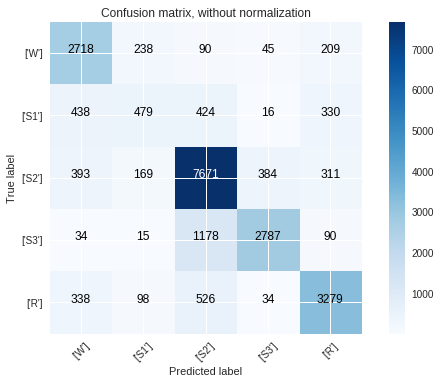

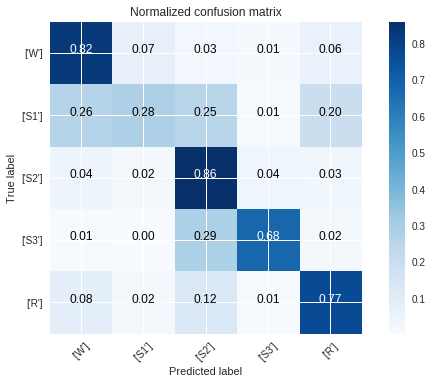

In [0]:
xxx=[]
preds = []
gt = []
u=[]
total_max=[]
j=-1
for record in tqdm(test_dict):
    all_rows = test_dict[record]['x']
    s=record +'.npy'
    X2=np.load(s)
    X22=X2.reshape((len(X2)),92,1)
    #j=-1
    
    
    
    for batch_hyp in chunker(range(all_rows.shape[0])):


        X = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
        d=X
        Y = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]
        
        X2=X22[min(batch_hyp):max(batch_hyp)+1, ...]
        
        X2 = np.expand_dims(X2,0)

        X = np.expand_dims(X, 0)

        X = rescale_array(X)

        Y_pred = model.predict([X,X2])
        j=j+1
        t=Y_pred
        if j>=1:
          a = t.reshape(t.shape[0]*t.shape[1],5)
          u = np.concatenate((u,a),axis=0)
          
          d= d.reshape(d.shape[0],3000)
          xxx = np.concatenate((xxx,d),axis=0)
          
        else :
          a = t.reshape(t.shape[0]*t.shape[1],5)
          u = a
          
          d= d.reshape(d.shape[0],3000)
          xxx = d
        
        
        
        
        Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()
    
        gt += Y.ravel().tolist()
        preds += Y_pred
         
    
    
    
    
f1 = f1_score(gt, preds, average="macro")

print("Seq Test f1 score : %s "% f1)

acc = accuracy_score(gt, preds)

print("Seq Test accuracy score : %s "% acc)

print(classification_report(gt, preds))


class_names=np.array([["W"], ["S1"],["S2"],["S3"],["R"]])
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

cnf_matrix = confusion_matrix(gt, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
q = np.zeros(len(u))##true or false
p = np.zeros(len(u))## Ratio
g=np.zeros(len(u)) ###Class
sec=np.zeros(len(u)) ###Secend prediction
for i in range(len(u)):
        z=max(u[i])
        ee = np.delete(u[i], np.argmax(u[i]))
      
      
      
        if np.argmax(u[i])>np.argmax(ee):
          sec[i]=np.argmax(ee)
        elif np.argmax(u[i])<np.argmax(ee):
          sec[i]=np.argmax(ee)+1
        elif np.argmax(u[i])==np.argmax(ee):
          sec[i]=np.argmax(ee)+1
        
        
        
        
       
        o=max(ee)
        p[i]=z/o
        g[i]=gt[i]
        if gt[i]==np.argmax(u[i]):
          q[i]=1
        else :q[i]=0
          


In [0]:
u.shape

(29943, 5)

In [0]:
import pandas as pd 
F = np.concatenate([[q],[p],[g],[preds],[sec]],axis=0)          
F=np.transpose(F)
F = pd.DataFrame(F,columns=['true|false','Ratio','Class','Prediction','Secend prediction'])        
TotalDataset= pd.concat([F],ignore_index=False)
F.to_excel("output.xlsx") 
from google.colab import files
files.download("output.xlsx")

In [0]:
#@title Pretrain model { form-width: "20%" }
import numpy as np
import keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D,concatenate, SpatialDropout1D, TimeDistributed, Bidirectional, LSTM
from keras.utils import plot_model
from keras import optimizers, losses, activations, models
#y_ptrain = keras.utils.to_categorical(y_ptrain, num_classes=5)
#y_ptest = keras.utils.to_categorical(y_ptest, num_classes=5)


mode = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# in the first layer, you must specify the expected input data shape:
# here, 20-dimensional vectors.
mode.add(Dense(50, activation='relu', input_dim=92))
mode.add(Dropout(0.5))
mode.add(Dense(20, activation='relu'))
mode.add(Dense(20, activation='relu'))
mode.add(Dense(10, activation='relu'))
#mode.add(Dense(30, activation='relu'))
mode.add(Dropout(0.2))
mode.add(Dense(5, activation='softmax'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
mode.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])




In [0]:
pre1=[]
y1_pre=[]
pre3=[]
y3_pre=[]
pre4=[]
y4_pre=[]
u=0
v=0
w=0
for record in tqdm(train_dict):
    s=record +'.npy'
    Fe=np.load(s)
    all_cols=train_dict[record]['y']
    for i in range(len(all_cols)):
      if all_cols[i]==1 & all_cols[i-1]==1 & all_cols[i-2]==1:
        if u==0:
          pre1=all_rows[i-1]
          u=u+1
          y1_pre+=[1]
          
        else: 
             pre1 = np.concatenate((pre1,all_rows[i]),axis=0)
             y1_pre+=[1]
              
      if all_cols[i]==3 & all_cols[i-1]==3 & all_cols[i-2]==3 :
        if v==0:
          pre3=all_rows[i]
          v=v+1
          y3_pre+=[3]
          
        else: 
             pre3 = np.concatenate((pre3,all_rows[i]),axis=0)
             y3_pre+=[3]
              
              
              
      if all_cols[i]==4 & all_cols[i-1]==4 & all_cols[i-2]==4:
        if w==0:
          pre4=all_rows[i]
          w=w+1
          y4_pre+=[4]
          
        else: 
             pre4 = np.concatenate((pre4,all_rows[i]),axis=0)
             y4_pre+=[4]        
          
pre1= pre1.reshape(int(len(pre1)/3000),3000)
pre3= pre3.reshape(int(len(pre3)/3000),3000)
pre4= pre4.reshape(int(len(pre4)/3000),3000)

In [0]:
idx = np.random.randint(len(pre1), size=150)
a=pre1[idx,:]
asim=a
aa=numpy.ones((150,1))*1

idx = np.random.randint(len(pre3), size=120)
b=pre3[idx,:]
bb=numpy.ones((120,1))*3

idx = np.random.randint(len(pre4), size=120)
c=pre4[idx,:]
cc=numpy.ones((120,1))*4
pre_x = np.concatenate((a,b,c),axis=0)
pre_y=np.concatenate((aa,bb,cc),axis=0)

In [0]:
for record in tqdm(train_dict):
    y= train_dict[record]['y']
    s=record +'.npy'
    Fe=np.load(s)
    for i in range(len(y)):
      if y[i]==1:
        
   

  0%|          | 0/22 [00:00<?, ?it/s]

Epoch 1/250
420/420 [==============================] - 0s 48us/step - loss: 0.5039 - acc: 0.8929
Epoch 2/250
420/420 [==============================] - 0s 49us/step - loss: 0.5364 - acc: 0.8833
Epoch 3/250
420/420 [==============================] - 0s 50us/step - loss: 0.4418 - acc: 0.9071
Epoch 4/250
420/420 [==============================] - 0s 43us/step - loss: 0.3650 - acc: 0.9071
Epoch 5/250
420/420 [==============================] - 0s 47us/step - loss: 0.2555 - acc: 0.9143
Epoch 6/250
420/420 [==============================] - 0s 51us/step - loss: 0.2413 - acc: 0.9524
Epoch 7/250
420/420 [==============================] - 0s 48us/step - loss: 0.2232 - acc: 0.9452
Epoch 8/250
420/420 [==============================] - 0s 44us/step - loss: 0.2169 - acc: 0.9381
Epoch 9/250
420/420 [==============================] - 0s 41us/step - loss: 0.2279 - acc: 0.9333
Epoch 10/250
420/420 [==============================] - 0s 45us/step - loss: 0.1967 - acc: 0.9333
Epoch 11/250
420/420 [=======

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
  5%|▍         | 1/22 [00:07<02:43,  7.79s/it]

[[153   0   0   0   0]
 [  5   0   1   0   0]
 [  0   0 110   0   1]
 [  0   0   8  90   0]
 [  0   0   0   0  52]]
Epoch 1/250
563/563 [==============================] - 0s 48us/step - loss: 0.6331 - acc: 0.8845
Epoch 2/250
563/563 [==============================] - 0s 46us/step - loss: 0.5947 - acc: 0.8934
Epoch 3/250
563/563 [==============================] - 0s 48us/step - loss: 0.4416 - acc: 0.9165
Epoch 4/250
563/563 [==============================] - 0s 47us/step - loss: 0.4555 - acc: 0.9041
Epoch 5/250
563/563 [==============================] - 0s 50us/step - loss: 0.4540 - acc: 0.9272
Epoch 6/250
563/563 [==============================] - 0s 50us/step - loss: 0.4267 - acc: 0.9272
Epoch 7/250
563/563 [==============================] - 0s 51us/step - loss: 0.4311 - acc: 0.9147
Epoch 8/250
563/563 [==============================] - 0s 51us/step - loss: 0.4461 - acc: 0.9183
Epoch 9/250
563/563 [==============================] - 0s 52us/step - loss: 0.3525 - acc: 0.9361
Epoch 10/25

  9%|▉         | 2/22 [00:17<02:47,  8.37s/it]

Epoch 1/250
567/567 [==============================] - 0s 50us/step - loss: 0.7824 - acc: 0.8183
Epoch 2/250
567/567 [==============================] - 0s 74us/step - loss: 0.6710 - acc: 0.8589
Epoch 3/250
567/567 [==============================] - 0s 49us/step - loss: 0.4991 - acc: 0.8836
Epoch 4/250
567/567 [==============================] - 0s 50us/step - loss: 0.5102 - acc: 0.9030
Epoch 5/250
567/567 [==============================] - 0s 49us/step - loss: 0.4888 - acc: 0.9083
Epoch 6/250
567/567 [==============================] - 0s 50us/step - loss: 0.4824 - acc: 0.9012
Epoch 7/250
567/567 [==============================] - 0s 54us/step - loss: 0.3943 - acc: 0.9012
Epoch 8/250
567/567 [==============================] - 0s 57us/step - loss: 0.3209 - acc: 0.9206
Epoch 9/250
567/567 [==============================] - 0s 48us/step - loss: 0.4038 - acc: 0.9206
Epoch 10/250
567/567 [==============================] - 0s 51us/step - loss: 0.3669 - acc: 0.9153
Epoch 11/250
567/567 [=======

 14%|█▎        | 3/22 [00:26<02:44,  8.68s/it]

Seq Test accuracy score : 0.6825396825396826 
              precision    recall  f1-score   support

         0.0       0.47      0.77      0.59        56
         1.0       0.00      0.00      0.00        67
         2.0       0.64      0.90      0.74       182
         3.0       0.91      0.68      0.78       205
         4.0       0.63      0.74      0.68        57

   micro avg       0.68      0.68      0.68       567
   macro avg       0.53      0.62      0.56       567
weighted avg       0.64      0.68      0.65       567

[[ 43   0   4   6   3]
 [ 40   0  12   2  13]
 [  4   0 163   6   9]
 [  1   0  65 139   0]
 [  3   0  12   0  42]]
[[262   0   0   5   0]
 [  1   0   0   0   0]
 [  0   0  80   0   0]
 [  0   0   5 140   0]
 [  0   0  21   0  53]]
Epoch 1/250
527/527 [==============================] - 0s 53us/step - loss: 0.8417 - acc: 0.8330
Epoch 2/250
527/527 [==============================] - 0s 51us/step - loss: 0.7295 - acc: 0.8520
Epoch 3/250
527/527 [==================

 18%|█▊        | 4/22 [00:35<02:37,  8.75s/it]

Seq Test accuracy score : 0.6698292220113852 
              precision    recall  f1-score   support

         0.0       0.67      0.75      0.71        68
         1.0       0.00      0.00      0.00        36
         2.0       0.75      0.66      0.71       217
         3.0       0.66      0.74      0.69       114
         4.0       0.56      0.80      0.66        92

   micro avg       0.67      0.67      0.67       527
   macro avg       0.53      0.59      0.55       527
weighted avg       0.64      0.67      0.65       527

[[ 51   0   1   4  12]
 [ 12   0   5   3  16]
 [ 11   0 144  33  29]
 [  1   0  28  84   1]
 [  1   0  13   4  74]]
[[ 76   0   0   0   0]
 [  0   0   0   0   3]
 [  0   0  97   9   6]
 [  0   0   2 166   0]
 [  0   0   0   0 168]]
Epoch 1/250
464/464 [==============================] - 0s 52us/step - loss: 1.9609 - acc: 0.5000
Epoch 2/250
464/464 [==============================] - 0s 51us/step - loss: 1.1930 - acc: 0.6767
Epoch 3/250
464/464 [==================

 23%|██▎       | 5/22 [00:43<02:24,  8.48s/it]

              precision    recall  f1-score   support

         0.0       0.10      0.87      0.17        15
         1.0       0.00      0.00      0.00        13
         2.0       0.66      0.24      0.35       245
         3.0       0.98      0.38      0.54       112
         4.0       0.15      0.37      0.21        79

   micro avg       0.31      0.31      0.31       464
   macro avg       0.38      0.37      0.26       464
weighted avg       0.61      0.31      0.36       464

[[ 13   0   0   0   2]
 [  3   0   0   0  10]
 [ 40   0  59   1 145]
 [ 31   0  29  42  10]
 [ 49   0   1   0  29]]
[[111   0   0   0]
 [257   0   0   0]
 [ 17   0   0   0]
 [ 79   0   0   0]]
Epoch 1/250
401/401 [==============================] - 0s 61us/step - loss: 1.8295 - acc: 0.6933
Epoch 2/250
401/401 [==============================] - 0s 62us/step - loss: 1.5437 - acc: 0.7406
Epoch 3/250
401/401 [==============================] - 0s 61us/step - loss: 1.0372 - acc: 0.8055
Epoch 4/250
401/401 [======

 27%|██▋       | 6/22 [00:51<02:11,  8.20s/it]

Seq Test accuracy score : 0.6907730673316709 
              precision    recall  f1-score   support

         0.0       0.20      0.57      0.29        14
         1.0       0.00      0.00      0.00        18
         2.0       0.92      0.68      0.79       249
         3.0       0.55      0.76      0.64        63
         4.0       0.58      0.89      0.70        57

   micro avg       0.69      0.69      0.69       401
   macro avg       0.45      0.58      0.48       401
weighted avg       0.75      0.69      0.70       401

[[  8   0   1   0   5]
 [  6   0   6   0   6]
 [ 13   0 170  40  26]
 [ 11   0   4  48   0]
 [  3   0   3   0  51]]
[[112   0   0   0]
 [  0 137   3   7]
 [  0   0  48   0]
 [  0   0   0  94]]
Epoch 1/250
514/514 [==============================] - 0s 48us/step - loss: 0.2508 - acc: 0.9533
Epoch 2/250
514/514 [==============================] - 0s 45us/step - loss: 0.2082 - acc: 0.9669
Epoch 3/250
514/514 [==============================] - 0s 44us/step - loss: 0.

 32%|███▏      | 7/22 [01:00<02:06,  8.44s/it]

Seq Test accuracy score : 0.6498054474708171 
              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71        36
         1.0       0.00      0.00      0.00        53
         2.0       0.96      0.62      0.75       301
         3.0       0.49      1.00      0.65        54
         4.0       0.39      0.90      0.55        70

   micro avg       0.65      0.65      0.65       514
   macro avg       0.49      0.67      0.53       514
weighted avg       0.71      0.65      0.63       514

[[ 30   0   0   0   6]
 [  6   0   2   0  45]
 [ 11   0 187  57  46]
 [  0   0   0  54   0]
 [  1   0   6   0  63]]
[[119   0   0   0   0]
 [  0   1   2   0   1]
 [  0   3 188   1   4]
 [  0   0   0  93   0]
 [  0   0   1   0 101]]
Epoch 1/250
767/767 [==============================] - 0s 40us/step - loss: 0.6355 - acc: 0.8540
Epoch 2/250
767/767 [==============================] - 0s 40us/step - loss: 0.5572 - acc: 0.8657
Epoch 3/250
767/767 [==================

 36%|███▋      | 8/22 [01:11<02:08,  9.15s/it]

Seq Test accuracy score : 0.5554106910039114 
              precision    recall  f1-score   support

         0.0       0.35      0.92      0.51        49
         1.0       0.00      0.00      0.00        99
         2.0       0.68      0.73      0.70       371
         3.0       0.00      0.00      0.00       109
         4.0       0.46      0.81      0.59       139

   micro avg       0.56      0.56      0.56       767
   macro avg       0.30      0.49      0.36       767
weighted avg       0.43      0.56      0.48       767

[[ 45   0   1   0   3]
 [ 44   0   9   0  46]
 [ 20   0 269   1  81]
 [  2   0 107   0   0]
 [ 16   0  11   0 112]]
[[139   0   0   0   0]
 [ 10   1   0   0   8]
 [  2   1 458   0   0]
 [  0   0   1   0   0]
 [ 38   0   0   0 109]]
Epoch 1/250
637/637 [==============================] - 0s 42us/step - loss: 0.3335 - acc: 0.9137
Epoch 2/250
637/637 [==============================] - 0s 52us/step - loss: 0.2837 - acc: 0.9278
Epoch 3/250
637/637 [==================

 41%|████      | 9/22 [01:20<01:59,  9.19s/it]

[[306   0   0   0]
 [ 24   0   0   0]
 [  0   0 221   0]
 [  3   0   0  83]]
Epoch 1/250
460/460 [==============================] - 0s 52us/step - loss: 2.9197 - acc: 0.6957
Epoch 2/250
460/460 [==============================] - 0s 50us/step - loss: 2.3346 - acc: 0.7500
Epoch 3/250
460/460 [==============================] - 0s 49us/step - loss: 2.0477 - acc: 0.7826
Epoch 4/250
460/460 [==============================] - 0s 49us/step - loss: 1.2608 - acc: 0.8326
Epoch 5/250
460/460 [==============================] - 0s 48us/step - loss: 0.9798 - acc: 0.8609
Epoch 6/250
460/460 [==============================] - 0s 52us/step - loss: 0.6222 - acc: 0.9109
Epoch 7/250
460/460 [==============================] - 0s 51us/step - loss: 0.4737 - acc: 0.9326
Epoch 8/250
460/460 [==============================] - 0s 71us/step - loss: 0.3898 - acc: 0.9196
Epoch 9/250
460/460 [==============================] - 0s 70us/step - loss: 0.3552 - acc: 0.9435
Epoch 10/250
460/460 [============================

 45%|████▌     | 10/22 [01:28<01:45,  8.79s/it]

Seq Test accuracy score : 0.691304347826087 
              precision    recall  f1-score   support

         0.0       0.91      0.32      0.48        62
         1.0       0.00      0.00      0.00        40
         2.0       0.65      0.88      0.75       128
         3.0       0.96      0.82      0.88       139
         4.0       0.49      0.78      0.60        91

   micro avg       0.69      0.69      0.69       460
   macro avg       0.60      0.56      0.54       460
weighted avg       0.69      0.69      0.66       460

[[ 20   0   9   1  32]
 [  0   0   8   2  30]
 [  1   0 113   2  12]
 [  1   0  24 114   0]
 [  0   0  20   0  71]]
[[  1   0   1   0   5]
 [  0   0   1   0   3]
 [  0   0 284   0   0]
 [  0   0  24  56   0]
 [  0   0   0   0  85]]
Epoch 1/250
472/472 [==============================] - 0s 53us/step - loss: 0.1745 - acc: 0.9555
Epoch 2/250
472/472 [==============================] - 0s 54us/step - loss: 0.2079 - acc: 0.9576
Epoch 3/250
472/472 [===================

 50%|█████     | 11/22 [01:36<01:35,  8.70s/it]

              precision    recall  f1-score   support

         0.0       0.73      0.35      0.48        62
         1.0       0.00      0.00      0.00        66
         2.0       0.46      0.81      0.59       130
         3.0       0.88      0.43      0.58       172
         4.0       0.27      0.86      0.41        42

   micro avg       0.50      0.50      0.50       472
   macro avg       0.47      0.49      0.41       472
weighted avg       0.57      0.50      0.47       472

[[ 22   0   6   5  29]
 [  4   0  11   1  50]
 [  4   0 105   4  17]
 [  0   0  98  74   0]
 [  0   0   6   0  36]]
[[ 10   0   1   1   0]
 [  0   1   1   0   6]
 [  0   0 223   0   0]
 [  0   0  50  62   0]
 [  0   0   0   0 117]]
Epoch 1/250
509/509 [==============================] - 0s 48us/step - loss: 0.3202 - acc: 0.9312
Epoch 2/250
509/509 [==============================] - 0s 53us/step - loss: 0.3660 - acc: 0.9194
Epoch 3/250
509/509 [==============================] - 0s 54us/step - loss: 0.3277 - 

 55%|█████▍    | 12/22 [01:45<01:27,  8.73s/it]

Seq Test accuracy score : 0.618860510805501 
              precision    recall  f1-score   support

         0.0       0.60      0.66      0.62        38
         1.0       0.00      0.00      0.00        75
         2.0       0.47      0.88      0.62       119
         3.0       1.00      0.68      0.81       222
         4.0       0.35      0.60      0.45        55

   micro avg       0.62      0.62      0.62       509
   macro avg       0.48      0.56      0.50       509
weighted avg       0.63      0.62      0.59       509

[[ 25   0   5   0   8]
 [ 15   0  20   0  40]
 [  2   0 105   0  12]
 [  0   0  70 152   0]
 [  0   0  22   0  33]]
[[ 36   0   0   0   0]
 [  0   0   9   0  19]
 [  0   0 245   0   4]
 [  0   0  11  15   0]
 [  0   0   7   0 163]]
Epoch 1/250
517/517 [==============================] - 0s 55us/step - loss: 0.3923 - acc: 0.8936
Epoch 2/250
517/517 [==============================] - 0s 54us/step - loss: 0.3629 - acc: 0.8994
Epoch 3/250
517/517 [===================

 59%|█████▉    | 13/22 [01:55<01:21,  9.05s/it]

Seq Test accuracy score : 0.6228239845261122 
              precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        75
         1.0       0.00      0.00      0.00       108
         2.0       0.76      0.81      0.78       176
         3.0       0.94      0.71      0.81       112
         4.0       0.23      0.83      0.36        46

   micro avg       0.62      0.62      0.62       517
   macro avg       0.54      0.64      0.55       517
weighted avg       0.60      0.62      0.59       517

[[ 63   0   2   0  10]
 [ 17   0   3   0  88]
 [  1   0 142   4  29]
 [  0   0  33  79   0]
 [  0   0   7   1  38]]
[[ 31   0   0   0   5]
 [  3   0   1   0   9]
 [  0   0 216   0   4]
 [  0   0   1  67   0]
 [  0   0   1   0 179]]
Epoch 1/250
473/473 [==============================] - 0s 49us/step - loss: 1.0700 - acc: 0.8224
Epoch 2/250
473/473 [==============================] - 0s 58us/step - loss: 0.9333 - acc: 0.8499
Epoch 3/250
473/473 [==================

 64%|██████▎   | 14/22 [02:03<01:10,  8.80s/it]

              precision    recall  f1-score   support

         0.0       0.66      0.85      0.74        73
         1.0       0.00      0.00      0.00        69
         2.0       0.48      0.93      0.63       139
         3.0       0.89      0.48      0.62       143
         4.0       0.55      0.37      0.44        49

   micro avg       0.59      0.59      0.59       473
   macro avg       0.52      0.52      0.49       473
weighted avg       0.57      0.59      0.53       473

[[ 62   0   7   1   3]
 [ 27   0  29   3  10]
 [  4   0 129   4   2]
 [  0   0  75  68   0]
 [  1   0  30   0  18]]
[[ 70   0   0   0   1]
 [  1   0   6   1   2]
 [  0   0 326   2   0]
 [  0   0   9  16   0]
 [  0   0  11   0  28]]
Epoch 1/250
465/465 [==============================] - 0s 54us/step - loss: 1.9206 - acc: 0.6043
Epoch 2/250
465/465 [==============================] - 0s 51us/step - loss: 2.0570 - acc: 0.5226
Epoch 3/250
465/465 [==============================] - 0s 54us/step - loss: 1.6785 - 

 68%|██████▊   | 15/22 [02:11<01:00,  8.57s/it]

Seq Test accuracy score : 0.4021505376344086 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        98
         1.0       0.00      0.00      0.00       122
         2.0       0.40      1.00      0.57       187
         3.0       0.00      0.00      0.00        24
         4.0       0.00      0.00      0.00        34

   micro avg       0.40      0.40      0.40       465
   macro avg       0.08      0.20      0.11       465
weighted avg       0.16      0.40      0.23       465

[[  0   0  98   0   0]
 [  0   0 122   0   0]
 [  0   0 187   0   0]
 [  0   0  24   0   0]
 [  0   0  34   0   0]]
[[ 32   0   0   0  24]
 [  0   0   4   0  45]
 [  0   0 250  12   0]
 [  0   0   2  19   0]
 [  0   0   1   0  76]]
Epoch 1/250
471/471 [==============================] - 0s 52us/step - loss: 1.0124 - acc: 0.6412
Epoch 2/250
471/471 [==============================] - 0s 54us/step - loss: 0.9987 - acc: 0.6582
Epoch 3/250
471/471 [==================

 73%|███████▎  | 16/22 [02:19<00:50,  8.40s/it]

Seq Test accuracy score : 0.3481953290870488 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        96
         1.0       0.00      0.00      0.00        82
         2.0       0.35      1.00      0.52       164
         3.0       0.00      0.00      0.00        54
         4.0       0.00      0.00      0.00        75

   micro avg       0.35      0.35      0.35       471
   macro avg       0.07      0.20      0.10       471
weighted avg       0.12      0.35      0.18       471

[[  0   0  96   0   0]
 [  0   0  82   0   0]
 [  0   0 164   0   0]
 [  0   0  54   0   0]
 [  0   0  75   0   0]]
[[ 44   0   0   0   0]
 [  3   0   6   0   0]
 [  0   0 300   0   0]
 [  0   0   8   0   0]
 [  0   0   4   0 106]]
Epoch 1/250
461/461 [==============================] - 0s 53us/step - loss: 1.0997 - acc: 0.5358
Epoch 2/250
461/461 [==============================] - 0s 52us/step - loss: 1.1194 - acc: 0.5336
Epoch 3/250
461/461 [==================

 77%|███████▋  | 17/22 [02:27<00:40,  8.18s/it]

Epoch 1/250
521/521 [==============================] - 0s 51us/step - loss: 2.5101 - acc: 0.3800
Epoch 2/250
521/521 [==============================] - 0s 50us/step - loss: 2.3375 - acc: 0.3820
Epoch 3/250
521/521 [==============================] - 0s 51us/step - loss: 2.1573 - acc: 0.3800
Epoch 4/250
521/521 [==============================] - 0s 53us/step - loss: 2.0206 - acc: 0.3800
Epoch 5/250
521/521 [==============================] - 0s 50us/step - loss: 1.8700 - acc: 0.3762
Epoch 6/250
521/521 [==============================] - 0s 52us/step - loss: 1.7801 - acc: 0.3762
Epoch 7/250
521/521 [==============================] - 0s 51us/step - loss: 1.6819 - acc: 0.3743
Epoch 8/250
521/521 [==============================] - 0s 56us/step - loss: 1.5745 - acc: 0.3800
Epoch 9/250
521/521 [==============================] - 0s 61us/step - loss: 1.5591 - acc: 0.3685
Epoch 10/250
521/521 [==============================] - 0s 49us/step - loss: 1.5031 - acc: 0.3724
Epoch 11/250
521/521 [=======

 82%|████████▏ | 18/22 [02:36<00:33,  8.39s/it]

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        43
         1.0       0.00      0.00      0.00        66
         2.0       0.26      1.00      0.42       137
         3.0       0.00      0.00      0.00       191
         4.0       0.00      0.00      0.00        84

   micro avg       0.26      0.26      0.26       521
   macro avg       0.05      0.20      0.08       521
weighted avg       0.07      0.26      0.11       521

[[  0   0  43   0   0]
 [  0   0  66   0   0]
 [  0   0 137   0   0]
 [  0   0 191   0   0]
 [  0   0  84   0   0]]
[[ 88   0   0   0   0]
 [  2   0   2   0   2]
 [  0   0 166   0   0]
 [  0   0  23  91   0]
 [  0   0   7   0 140]]
Epoch 1/250
490/490 [==============================] - 0s 48us/step - loss: 1.4086 - acc: 0.3510
Epoch 2/250
490/490 [==============================] - 0s 46us/step - loss: 1.3370 - acc: 0.4408
Epoch 3/250
490/490 [==============================] - 0s 44us/step - loss: 1.3431 - 

 86%|████████▋ | 19/22 [02:43<00:24,  8.17s/it]


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        23
         1.0       0.00      0.00      0.00        30
         2.0       0.26      1.00      0.41       126
         3.0       0.00      0.00      0.00       143
         4.0       0.00      0.00      0.00       168

   micro avg       0.26      0.26      0.26       490
   macro avg       0.05      0.20      0.08       490
weighted avg       0.07      0.26      0.11       490

[[  0   0  23   0   0]
 [  0   0  30   0   0]
 [  0   0 126   0   0]
 [  0   0 143   0   0]
 [  0   0 168   0   0]]
[[ 32   0   0   0]
 [  0 132   0   0]
 [  0   8 143   0]
 [  0  59   0 116]]
Epoch 1/250
513/513 [==============================] - 0s 57us/step - loss: 1.2190 - acc: 0.5185
Epoch 2/250
513/513 [==============================] - 0s 49us/step - loss: 1.1703 - acc: 0.5166
Epoch 3/250
513/513 [==============================] - 0s 46us/step - loss: 1.1428 - acc: 0.5400
Epoch 4/250
513/513 [=====

 91%|█████████ | 20/22 [02:52<00:16,  8.47s/it]

Seq Test accuracy score : 0.34307992202729043 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        41
         1.0       0.00      0.00      0.00        34
         2.0       0.34      1.00      0.51       176
         3.0       0.00      0.00      0.00       166
         4.0       0.00      0.00      0.00        96

   micro avg       0.34      0.34      0.34       513
   macro avg       0.07      0.20      0.10       513
weighted avg       0.12      0.34      0.18       513

[[  0   0  41   0   0]
 [  0   0  34   0   0]
 [  0   0 176   0   0]
 [  0   0 166   0   0]
 [  0   0  96   0   0]]
[[ 29   0   0   0]
 [  0 276   0   0]
 [  0  14  23   0]
 [  0  24   0 147]]
Epoch 1/250
472/472 [==============================] - 0s 50us/step - loss: 0.9833 - acc: 0.7669
Epoch 2/250
472/472 [==============================] - 0s 47us/step - loss: 0.9659 - acc: 0.7669
Epoch 3/250
472/472 [==============================] - 0s 46us/step - loss: 0

 95%|█████████▌| 21/22 [03:00<00:08,  8.26s/it]

Seq Test accuracy score : 0.2733050847457627 
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        82
         1.0       0.00      0.00      0.00        71
         2.0       0.27      1.00      0.43       129
         3.0       0.00      0.00      0.00        91
         4.0       0.00      0.00      0.00        99

   micro avg       0.27      0.27      0.27       472
   macro avg       0.05      0.20      0.09       472
weighted avg       0.07      0.27      0.12       472

[[  0   0  82   0   0]
 [  0   0  71   0   0]
 [  0   0 129   0   0]
 [  0   0  91   0   0]
 [  0   0  99   0   0]]
[[  6   0   0   0   2]
 [  0   0   2   0   0]
 [  0   0 351   0   0]
 [  0   0   4  63   0]
 [  0   0   5   0  39]]
Epoch 1/250
459/459 [==============================] - 0s 51us/step - loss: 2.2005 - acc: 0.2397
Epoch 2/250
459/459 [==============================] - 0s 48us/step - loss: 2.1529 - acc: 0.2418
Epoch 3/250
459/459 [==================

100%|██████████| 22/22 [03:08<00:00,  8.07s/it]

[[  0   0   0   0  84]
 [  0   0   0   0 111]
 [  0   0   0   0 168]
 [  0   0   0   0  82]
 [  0   0   0   0  14]]
[[ 93   1   1   0   0]
 [ 15   0   2   0  12]
 [  2   0 106   5  13]
 [  0   0   1  93   0]
 [  1   0   0   0 114]]
Seq Test f1 score : 0.6906357679074638 
Seq Test accuracy score : 0.759576567686373 
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      3300
           1       0.48      0.28      0.36      1687
           2       0.78      0.86      0.82      8928
           3       0.85      0.68      0.76      4104
           4       0.78      0.77      0.77      4275

   micro avg       0.76      0.76      0.76     22294
   macro avg       0.72      0.68      0.69     22294
weighted avg       0.76      0.76      0.75     22294

Confusion matrix, without normalization
[[2718  238   90   45  209]
 [ 438  479  424   16  330]
 [ 393  169 7671  384  311]
 [  34   15 1178 2787   90]
 [ 338   98  526   34 3279]]


Normalized confusion matrix
[[0.82 0.07 0.03 0.01 0.06]
 [0.26 0.28 0.25 0.01 0.2 ]
 [0.04 0.02 0.86 0.04 0.03]
 [0.01 0.   0.29 0.68 0.02]
 [0.08 0.02 0.12 0.01 0.77]]


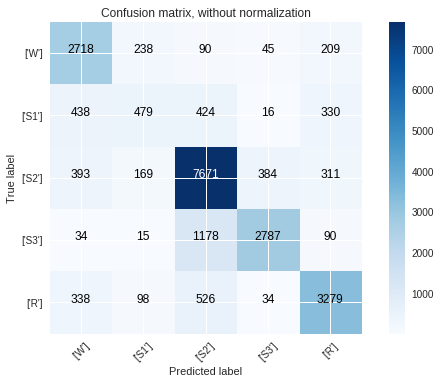

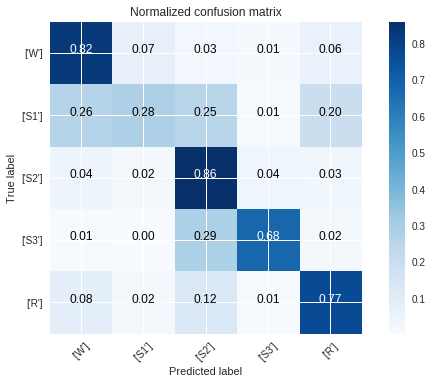

In [0]:
#@title Smi super { form-width: "20%" }
#model.load_weights(file_path)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
xxx=[]
preds = []
gt = []
u=[]
total_max=[]
Y_true=[]
j=-1



for record in tqdm(test_dict):
    all_rows = test_dict[record]['x']
    j=-1
    s=record +'.npy'
    X2=np.load(s)
    Fe=np.load(s)
    X22=X2.reshape((len(X2)),92,1)
    
    
    for batch_hyp in chunker(range(all_rows.shape[0])):
        X2=X22[min(batch_hyp):max(batch_hyp)+1, ...]
        
        X2 = np.expand_dims(X2,0)

        X = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
        d=X
        Y = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]

        X = np.expand_dims(X, 0)

        X = rescale_array(X)

        Y_pred = model.predict([X,X2])
        j=j+1
        t=Y_pred
        if j>=1:
                
          
          d= d.reshape(d.shape[0],3000)
          xxx = np.concatenate((xxx,d),axis=0)
          
          Y_true = np.concatenate((Y_true,Y),axis=0)
          
          
          a = t.reshape(t.shape[0]*t.shape[1],5)
          u = np.concatenate((u,a),axis=0)
    
          
        else :
          Y_true=Y
          
          d= d.reshape(d.shape[0],3000)
          xxx = d
          
          a = t.reshape(t.shape[0]*t.shape[1],5)
          u = a

        
        Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()
    
        gt += Y.ravel().tolist()
        preds += Y_pred
    #######soft_max analyis     
    sec=np.zeros(len(u))
    p=np.zeros((len(u),5))
    q=np.zeros(len(u))
    for i in range(len(u)):
        z=max(u[i])
        ee = np.delete(u[i], np.argmax(u[i]))
        o=max(ee)
       
        if np.argmax(u[i])>np.argmax(ee):
            sec[i]=np.argmax(ee)
        elif np.argmax(u[i])<np.argmax(ee):
            sec[i]=np.argmax(u[i])+1
        elif np.argmax(u[i])==np.argmax(ee) :
            sec[i]=np.argmax(u[i])+1
        p[i]=[z/o,np.argmax(u[i]),sec[i],i,Y_true[i]]
    
    p=p[p[:, 0].argsort()]
    
    
    zx=(len(p)-(len(p)%2))/2
    zx=int(zx)
   
    x1=np.zeros((zx,92)) 
    y1=np.zeros(zx)
    y_true1=np.zeros(zx)
    for i in range(zx):
        x1[i]=Fe[int(p[i,3])]
        y1[i]=p[i,1]
        y_true1[i]=p[i,4]
        
    x2=np.zeros((zx,92)) 
    y2=np.zeros(zx)
    y_true2=np.zeros(zx)
    for i in range(zx):
        x2[i]=Fe[int(p[len(p)-1-i,3])]
        y2[i]=p[len(p)-1-i,1]
        y_true2[i]=p[len(p)-1-i,4]
        
        
    x3=np.zeros((len(xxx)-2*zx,3000)) 
    y3=np.ones(len(xxx)-2*zx)
    y3=-y3
    y_true3=np.zeros(len(xxx)-2*zx)
    eee=p[:,4]
   
   # for i in range(zx):
    #    eee= np.delete(eee,0)
     #   eee=np.delete(eee,len(eee)-1)
    #y_true3=eee
    #y_true2=np.concatenate((y_true3,y_true3),axis=0)
    gu2=numpy.ones((len(y2),1))
    for i in range(len(y2)):
      gu2[i]=[y2[i]]
      
    gu1=numpy.ones((len(y1),1))
    for i in range(len(y1)):
      gu1[i]=[y1[i]]
    
    ####### 
    F_train=x2
    F_test=x1
    #F_semi=com_fea(x1)
    
    #F_train_new = np.concatenate((F_train,F_pre),axis=0)
    #y_train_new = np.concatenate((gu2,pre_y),axis=0)
    
    ############### 
    y_train_new = keras.utils.to_categorical(gu2, num_classes=5)
    y1 = keras.utils.to_categorical(gu1, num_classes=5)
    mode.fit(x2, y_train_new,
          epochs=250,
          batch_size=128,class_weight="balanced")
    score = mode.evaluate(F_test, y1, batch_size=128)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    Y_p = mode.predict(F_test)
    Y_p=Y_p.argmax(axis=-1)
    #y_ptest=y_ptest.argmax(axis=-1)
    f1 = f1_score(y_true1, Y_p, average="macro")

    #print("Seq Test f1 score : %s "% f1)

    acc = accuracy_score(y_true1, Y_p)

    print("Seq Test accuracy score : %s "% acc)

    print(classification_report(y_true1, Y_p))
    
    
    
    k=confusion_matrix(y_true1, Y_p)
    print(k)
    
    k=confusion_matrix(y_true2, y2)
    print(k)
 
    
    
    
    
    

    
    

        
    
    
    
f1 = f1_score(gt, preds, average="macro")

print("Seq Test f1 score : %s "% f1)

acc = accuracy_score(gt, preds)

print("Seq Test accuracy score : %s "% acc)

print(classification_report(gt, preds))


class_names=np.array([["W"], ["S1"],["S2"],["S3"],["R"]])
# Compute confusion matrix
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
    

cnf_matrix = confusion_matrix(gt, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [0]:
Fe[0]

array([-0.1 , -0.26, -0.49,  0.03,  0.28, -2.35,  0.14,  0.48,  1.27,
       -0.13,  0.54, -0.48,  0.06, -0.53, -0.55,  0.41,  0.08,  0.7 ,
        0.43, -1.64,  1.64, -1.61,  1.58, -1.64,  1.69, -1.71,  1.68,
       -1.76,  1.82, -1.74,  1.68, -1.63,  1.64, -1.64,  1.67, -1.71,
        1.64, -1.58,  1.47, -1.29,  1.13, -1.02,  0.77, -0.33, -0.07,
        0.34, -0.5 , -0.75, -0.04,  0.72,  0.41,  0.31, -2.59, -0.06,
        0.57, -0.17, -0.18,  1.54, -0.07,  0.01,  1.45, -0.16, -1.57,
       -0.67,  1.06, -0.2 ,  1.8 ,  0.14,  0.23,  0.26, -0.61,  1.79,
       -0.1 ,  0.22,  0.25, -0.31,  1.75, -0.37,  0.13,  0.51, -0.27,
        1.26, -0.37,  0.13,  0.52, -0.27,  1.26, -0.48, -1.06, -0.61,
       -0.34,  0.03])

# cnn_crf_model_20_folds.py

In [0]:
#@title Default title text
%cd/content/drive/My Drive
base_path = "pure_data"

files = sorted(glob(os.path.join(base_path, "*.npz")))

ids = list(set([x.split("/")[-1][:5] for x in files]))
list_f1 = []
list_acc = []
preds = []
gt = []
for id in ids:
    test_ids = {id}
    train_ids = set([x.split("/")[-1][:5] for x in files]) - test_ids

    train_val, test = [x for x in files if x.split("/")[-1][:5] in train_ids],\
                      [x for x in files if x.split("/")[-1][:5] in test_ids]

    train, val = train_test_split(train_val, test_size=0.1, random_state=1337)

    train_dict = {k: np.load(k) for k in train}
    test_dict = {k: np.load(k) for k in test}
    val_dict = {k: np.load(k) for k in val}

    model = get_model_cnn_crf(lr=0.0001)

    file_path = "cnn_crf_model_20_folds.h5"
    # model.load_weights(file_path)

    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    early = EarlyStopping(monitor="val_acc", mode="max", patience=20, verbose=1)
    redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=5, verbose=2)
    callbacks_list = [checkpoint, redonplat]  # early

    model.fit_generator(gen(train_dict, aug=False), validation_data=gen(val_dict), epochs=40, verbose=2,
                        steps_per_epoch=1000, validation_steps=300, callbacks=callbacks_list)
    model.load_weights(file_path)




    for record in tqdm(test_dict):
        all_rows = test_dict[record]['x']
        record_y_gt = []
        record_y_pred = []
        for batch_hyp in chunker(range(all_rows.shape[0])):


            X = all_rows[min(batch_hyp):max(batch_hyp)+1, ...]
            Y = test_dict[record]['y'][min(batch_hyp):max(batch_hyp)+1]

            X = np.expand_dims(X, 0)

            X = rescale_array(X)

            Y_pred = model.predict(X)
            Y_pred = Y_pred.argmax(axis=-1).ravel().tolist()

            gt += Y.ravel().tolist()
            preds += Y_pred

            record_y_gt += Y.ravel().tolist()
            record_y_pred += Y_pred


f1 = f1_score(gt, preds, average="macro")

acc = accuracy_score(gt, preds)
print("acc %s, f1 %s"%(acc, f1))
